# ***Patent Litigations Disparities: Who are the Real Winners and Losers?***

Research Question: How do  Litigation Outcomes impact the Profitibility and Reseach Investment of firms that are involved in Patent Lawsuits?

# ***Section 1: Introduction:***

Patent litigation is a double-edged sword; while it protects intellectual property, it also imposes financial and strategic costs on firms. Besides the private cost to firms, patents also shape market dynamics and innovation, thus, it is imperative to understand the true impact of patent litigations, in order to determine, if there is a net beenefit for society. To this end, this paper examines how litigation affects profitability and R&D investment in firms involved in patent disputes.

Patent lawsuits are costly, often exceeding potential revenue gains (Bessen & Meurer, 2012). Firms facing litigation tend to experience negative abnormal stock returns (Licht & Cremers, 2013), and litigation uncertainty disrupts long-term financial planning (Cohen et al., 2018). All of these could be disincentivizing the firms' future investment in research, which could lead to worse outcomes for society at large as medicines and improved technology take longer to develop. At the sane time, some plaintiffs can benefit as lawsuits can increase stock prices (Cremers et al., 2018) and serve as a competitive tool, particularly in tech industries (Kang & Nam, 2016).

The impact on R&D investment is less clear. Some firms increase R&D spending to strengthen their patent portfolios (Lin & Lin, 2021), while others, especially defendants, cut innovation budgets due to financial constraints (Hall, 2019). This paper analyzes how litigation outcomes such as dismissals, settlements and judgments can shape these effects using regression analysis on publicly traded firms and public records of patent litigations.

By comparing plaintiffs and defendants, this paper focuses on whether disparities exist. We explore whether litigations contribute primarily to a financial drain or a strategic advantage and whether it stimulates or stifles innovation. These insights are crucial for understanding the broader economic implications of the judicial system, with regards to patents, and whether it justifies the cost-benefit trade-off, in its current form.

# ***Section 2: Data Cleaning/Loading:***

In [101]:
#loading useful packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
!pip install stargazer
from stargazer.stargazer import Stargazer
from IPython.display import HTML



from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
#loading csv's that have been a little precleaned and merged to avoid excessive
#lines of code for the cleaning section

#loading up csv's into Data Frames
merged_cases_FJC = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_cases_JFC.csv')
subset_plaintiff_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_plaintiff_npm.csv')
subset_defendent_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_defendent_npm.csv')
subset_plaintiff_RnD = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_plaintiff_RnD.csv')
subset_defendent_RnD = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_defendent_RnD.csv')

In [103]:
#creating plaintiff-only df with all the Y and X variables
#(no index or geospatial data)
plaintiffs_complete = pd.merge(subset_plaintiff_npm,
                               subset_plaintiff_RnD[['case_row_id',
                                                     "delta_rnd_sales"]],
                               on="case_row_id",
                               how = 'outer')

plaintiffs_complete['case_length'] = np.log(plaintiffs_complete['case_length'])

plaintiffs_complete = plaintiffs_complete.drop_duplicates()
plaintiffs_complete = plaintiffs_complete[["case_number", "PLT", 'date_filed',
                            "delta_npm", "delta_rnd_sales","disp_dismissed",
                            "disp_settled", "disp_before_issue_joined",
                            "infringement_35_271", 'disp_judgment',
                            'judgment_monetary_award', 'judgment_injunction',
                            'judgment_ordered_loss', 'judgment_for_defendent',
                            'jury_demand_defendent', 'jury_demand_both',
                            "case_length", "info_tech", "health_care",
                            'materials','consumer_discretionary'
                             ]]

In [130]:
#creating defendent-only df with all the Y and X variables,
#(no index or geospatial data)
defendents_complete = pd.merge(subset_defendent_npm,
                               subset_defendent_RnD[['case_row_id',
                                                     "delta_rnd_sales"]],
                               on="case_row_id",
                               how = 'outer')

defendents_complete = defendents_complete.drop_duplicates()
defendents_complete = defendents_complete[["case_number", "DEF", 'date_filed',
                            "delta_npm", "delta_rnd_sales","disp_dismissed",
                            "disp_settled", "disp_before_issue_joined",
                            "infringement_35_271", 'disp_judgment',
                            'judgment_monetary_award', 'judgment_injunction',
                            'judgment_ordered_loss', 'judgment_for_defendent',
                            'jury_demand_defendent', 'jury_demand_both',
                            "case_length", "info_tech", "health_care",
                            'materials','consumer_discretionary'
                             ]]

**Data Sources:**
The data above are from the Assigned Kaggle Source, the Integrated Database of the Federal Judicial Center(FJC) and Finantial Data of publicly listed firms from the Compustat Database maintained by Wharton Research Data Services(WRDS). The FJC source added case outcomes such as whether ir was dismissed, went to judgment, settled etc. and the Compustat source added Financial data as well as GICS industry classifications. The merging process isnt shown as it was extremely long and included sending SQL queries to Compustat, Creating Dummies through complex processes(owing to structure of raw data) and matching financial data for firms with right timeline. The financial data from Compustat was of Quarterly Frequency and thus was matched based on the quarter of case filing and quarter of case closing, and cases that didn't span two distinct financial quarters were filtered out.



**Explanation of the Variables:**

Both dataframes defendents_complete and plaintiffs_complete conatain the same variables, for each unique case that was matched with WRDS dataset of publicly traded firms. The unit of observation is unique patent cases in both.

delta_npm: change in firm's net profit margin (0.01 = 1 percentage point)

delta_rnd_sales: change in firm's R&D to sales Ratio (0.01 = 1 percentage point)

disp_dismissed: dummy indicating whether a case was dismissed(reference represents cases that were resolved via judgment)

disp_settled: dummy that indicates if a case was dismissed, involved a settlement(this is only for rows where disp_dismissed = 1)

disp_before_issue_joined: dummy that indicates whether a case was dismissed before issue was joined(this means no legal proceedings were actually conducted between the case's filing and dismisssal, also only for rows with disp_dismissed = 1 )

infringement_35_271: dummy that indicates whether a case was filed Under 35 U.S.C. § 271(this essentially means that direct patent infringement was alleged by plaintiff)

case_length: the natural log of total days between a case's filing and closing(this variable has an extreme right skew, thus a natural log was applied)

info_tech: a dummy that indicates whether a given firm is classied as part of the information technology sector, under the GICS sector classification system(the reference category is all firms not in the info-tech sector)

health_care: a dummy that indicates whether a given firm is classied as part of the healthcare sector, under the GICS sector classification system(the reference category is all firms not in the info-tech sector)

Only two dummies for sector fixed effects were used because other sectors had very few occurrences in the merged dataset.

# ***Section 3: Summary Statistics:***

In [105]:
plaintiffs_complete.describe()

,delta_npm,delta_rnd_sales,disp_dismissed,disp_settled,disp_before_issue_joined,infringement_35_271,disp_judgment,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,judgment_for_defendent,jury_demand_defendent,jury_demand_both,case_length,info_tech,health_care,materials,consumer_discretionary
count,1147.000000,1157.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000,305.000000,305.000000,305.000000,305.000000,601.000000,601.000000,1147.000000,1147.000000,1147.000000,1147.000000,1147.000000
mean,8.741107,-0.764724,0.734089,0.619006,0.280732,0.517001,0.265911,0.065574,0.085246,0.032787,0.200000,0.038270,0.216306,5.879307,0.393200,0.258936,0.069747,0.118570
std,184.206505,82.468427,0.442010,0.485843,0.449553,0.499929,0.442010,0.247942,0.279706,0.178371,0.400657,0.192006,0.412068,0.955752,0.488674,0.438242,0.254832,0.323423
min,-348.520087,-1273.693333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.044522,0.000000,0.000000,0.000000,0.000000
25%,-0.033832,-0.003042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.167635,0.000000,0.000000,0.000000,0.000000
50%,-0.000521,0.000473,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.940171,0.000000,0.000000,0.000000,0.000000
75%,0.025305,0.010271,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.631341,1.000000,1.000000,0.000000,0.000000
max,3594.053333,1212.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.343078,1.000000,1.000000,1.000000,1.000000


Based on the summary stats for the plaintiffs, we can see that there is a strong right skew in the delta_npm. delta_rnd_sales aseems normally distributed around 0.

The case_length has already been logged, due to a large skew. It appears to be fairly evenly distributed betwen the range of 1 to 8.

The cateogrorical variables all appear to be evenly ditributed between 0 and 1.

In [106]:
defendents_complete.describe()

,delta_npm,delta_rnd_sales,disp_dismissed,disp_settled,disp_before_issue_joined,infringement_35_271,disp_judgment,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,judgment_for_defendent,jury_demand_defendent,jury_demand_both,case_length,info_tech,health_care,materials,consumer_discretionary
count,2557.000000,2559.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,470.000000,470.000000,470.00000,470.000000,2062.000000,2062.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
mean,-0.079224,0.013422,0.816191,0.604615,0.417677,0.633164,0.183809,0.055319,0.019149,0.02766,0.368085,0.027643,0.325412,5.586688,0.147438,0.386390,0.026203,0.154478
std,3.238747,0.720413,0.387404,0.489029,0.493273,0.482036,0.387404,0.228846,0.137194,0.16417,0.482799,0.163988,0.468642,0.966711,0.354612,0.487017,0.159769,0.361477
min,-152.326629,-7.251561,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000
25%,-0.019312,-0.001439,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.867534,0.000000,0.000000,0.000000,0.000000
50%,0.001188,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,5.583496,0.000000,0.000000,0.000000,0.000000
75%,0.021006,0.003631,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,6.311735,0.000000,1.000000,0.000000,0.000000
max,18.700229,31.787848,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,8.628019,1.000000,1.000000,1.000000,1.000000


Looking at the summary statistics for the defendants, we see that both the outcome variables are distributed around 0 but delta_npm appears to have a strong negative skew while delta_rnd_sales has strong positive skew. This could be an indication that litigatoin tends to lower defendants' profit margins but in some instances, leads to increase in research spending.

The categories once again seem evenly distributed with th exception of a larger proportion of 0s in disp_before_issue_joined.

Overall no major issues in both sets of plaintiff and defendant data, except for the skew inside the delta_npm variables

# ***Section 4: Data Visualizations:***

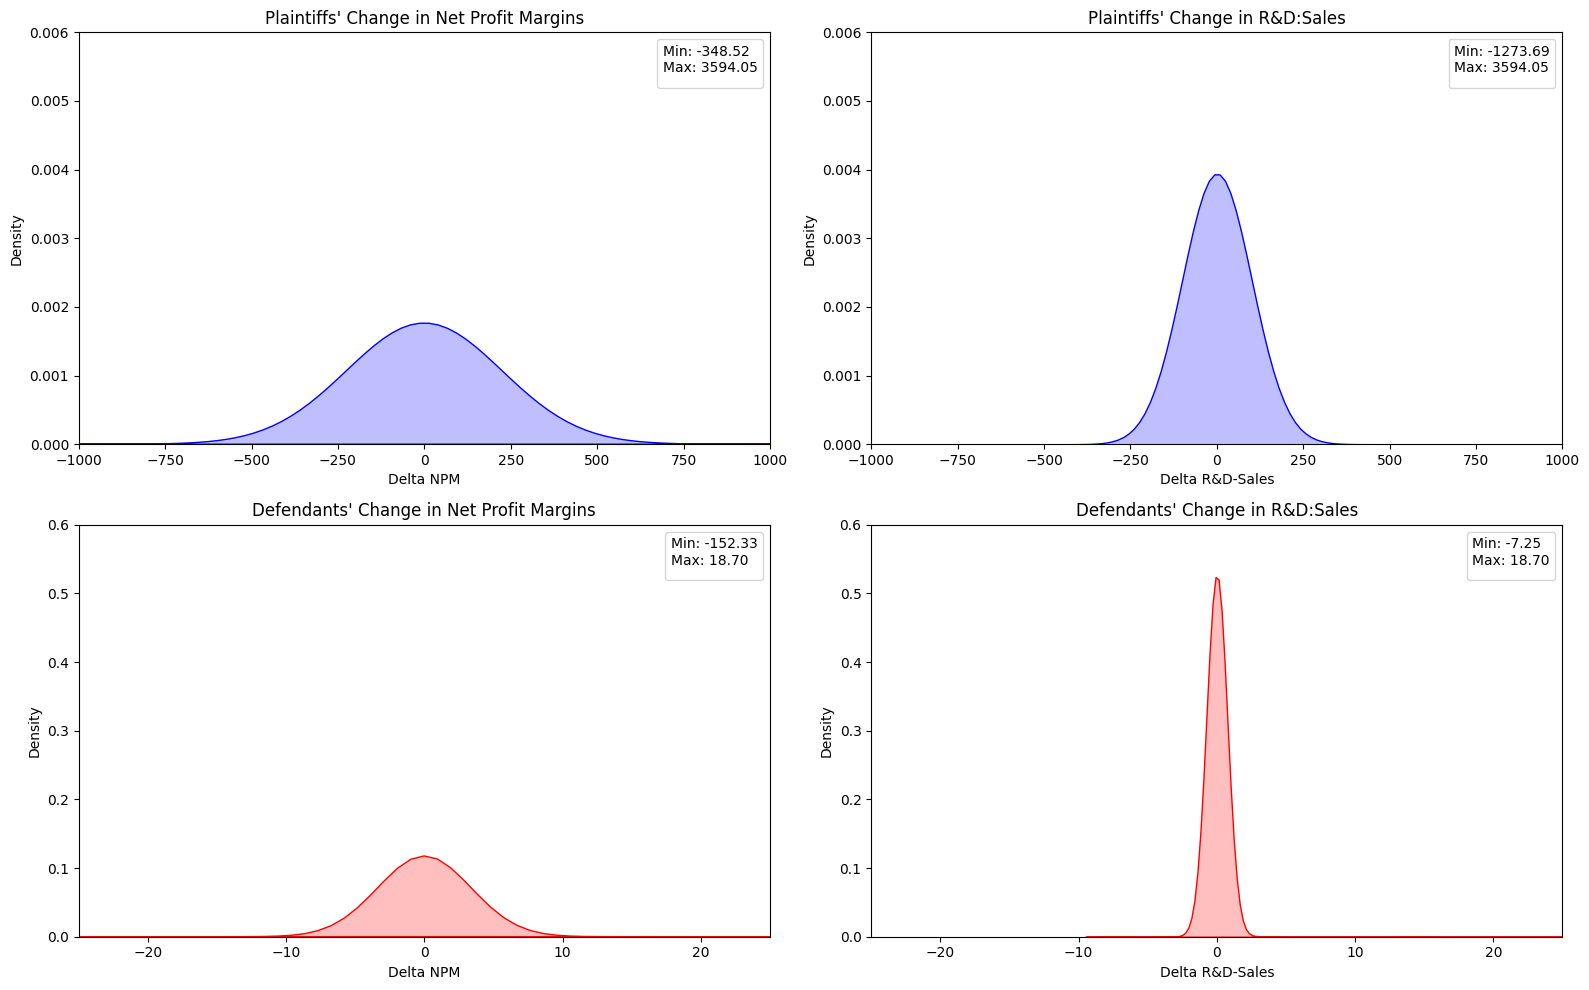

In [107]:
# Density plots for NPM and RnD:Sales
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot KDE for plaintiffs NPM
sns.kdeplot(plaintiffs_complete["delta_npm"],
            fill=True, color="blue", ax=axes[0,0],bw_adjust=5)
axes[0,0].set_title("Plaintiffs' Change in Net Profit Margins")
axes[0,0].set_xlabel("Delta NPM")
axes[0,0].set_ylabel("Density")
axes[0,0].grid(False)

# Plot KDE for defendants NPM
sns.kdeplot(defendents_complete["delta_npm"],
            fill=True, color="red", ax=axes[1,0],bw_adjust=5)
axes[1,0].set_title("Defendants' Change in Net Profit Margins")
axes[1,0].set_xlabel("Delta NPM")
axes[1,0].grid(False)

# Plot KDE for plaintiffs Rnd
sns.kdeplot(plaintiffs_complete["delta_rnd_sales"],
            fill=True, color="blue", ax=axes[0,1], bw_adjust=5)
axes[0,1].set_title("Plaintiffs' Change in R&D:Sales")
axes[0,1].set_xlabel("Delta R&D-Sales")
axes[0,1].set_ylabel("Density")
axes[0,1].grid(False)

# Plot KDE for defendants Rnd
sns.kdeplot(defendents_complete["delta_rnd_sales"],
            fill=True, color="red", ax=axes[1,1],bw_adjust=5)
axes[1,1].set_title("Defendants' Change in R&D:Sales")
axes[1,1].set_xlabel("Delta R&D-Sales")
axes[1,1].grid(False)


# Add min and max values as text legend
axes[0,0].legend(
    handles=[],
    title=f"Min: {plaintiffs_complete['delta_npm'].min():.2f}\nMax: {plaintiffs_complete['delta_npm'].max():.2f}",
    loc="upper right")
axes[1,0].legend(
    handles=[],
    title=f"Min: {defendents_complete['delta_npm'].min():.2f}\nMax: {defendents_complete['delta_npm'].max():.2f}",
    loc="upper right")
axes[0,1].legend(
    handles=[],
    title=f"Min: {plaintiffs_complete['delta_rnd_sales'].min():.2f}\nMax: {plaintiffs_complete['delta_npm'].max():.2f}",
    loc="upper right")
axes[1,1].legend(
    handles=[],
    title=f"Min: {defendents_complete['delta_rnd_sales'].min():.2f}\nMax: {defendents_complete['delta_npm'].max():.2f}",
    loc="upper right")



#zooming into the peaks
axes[0,0].set_ylim(0, 0.006)
axes[0,0].set_xlim(-1000, 1000)
axes[1,0].set_ylim(0, 0.6)
axes[1,0].set_xlim(-25, 25)
axes[0,1].set_ylim(0, 0.006)
axes[0,1].set_xlim(-1000, 1000)
axes[1,1].set_ylim(0, 0.6)
axes[1,1].set_xlim(-25, 25)

plt.tight_layout()
plt.show()

The above figure illusutrates the Kernel Density Estimated distributions for the outcome variables, for plaintiffs and defendants. Kernel Density plots better visualize these data as simple barcharts fail to effecitvely visualize intersting features of the distributions. The number of bins is either too small and leads one tall bar the others are near-invisible or if the number of bins is really high, it shows extremely thin bars, which are also hard to see.


We observe that Profit Margins have considerable smaller peaks and larger spreads, relative to R&D sales. All four appear normally distributed around zero, but in reality they are all heavily skewed, the visualizes simply zooms in to focus on the peaks.

Additionally, the distributions of changes in NPM and the R&D/sales ratio for defendants, appear to gave much lower spread compared to their plaintiff counterparts and the distributions of R&D change are much narrower than those of Net Profit Marings.

The skews, aren't entirely visible but denoted via the Max and Min values. We observe that for Net Profit Margins, the defendants have a left skew while plaintiffs have a strong right skew. This demonstrates disparities in outcomes, defendants tend to have decreases in profit margins while plaintiffs have increases.

We also observe that the R&D distributions for both plaintiffs and defendents are both skewed to the right, however, platintiffs' tail is considerably larger than the defendants.

In [108]:
plaintiffs_complete['delta_rnd_sales'].isna().sum()

np.int64(0)

In [109]:
plaintiffs_complete.isna().sum()

,0
case_number,10
PLT,10
date_filed,10
delta_npm,10
delta_rnd_sales,0
disp_dismissed,10
disp_settled,10
disp_before_issue_joined,10
infringement_35_271,10
disp_judgment,10


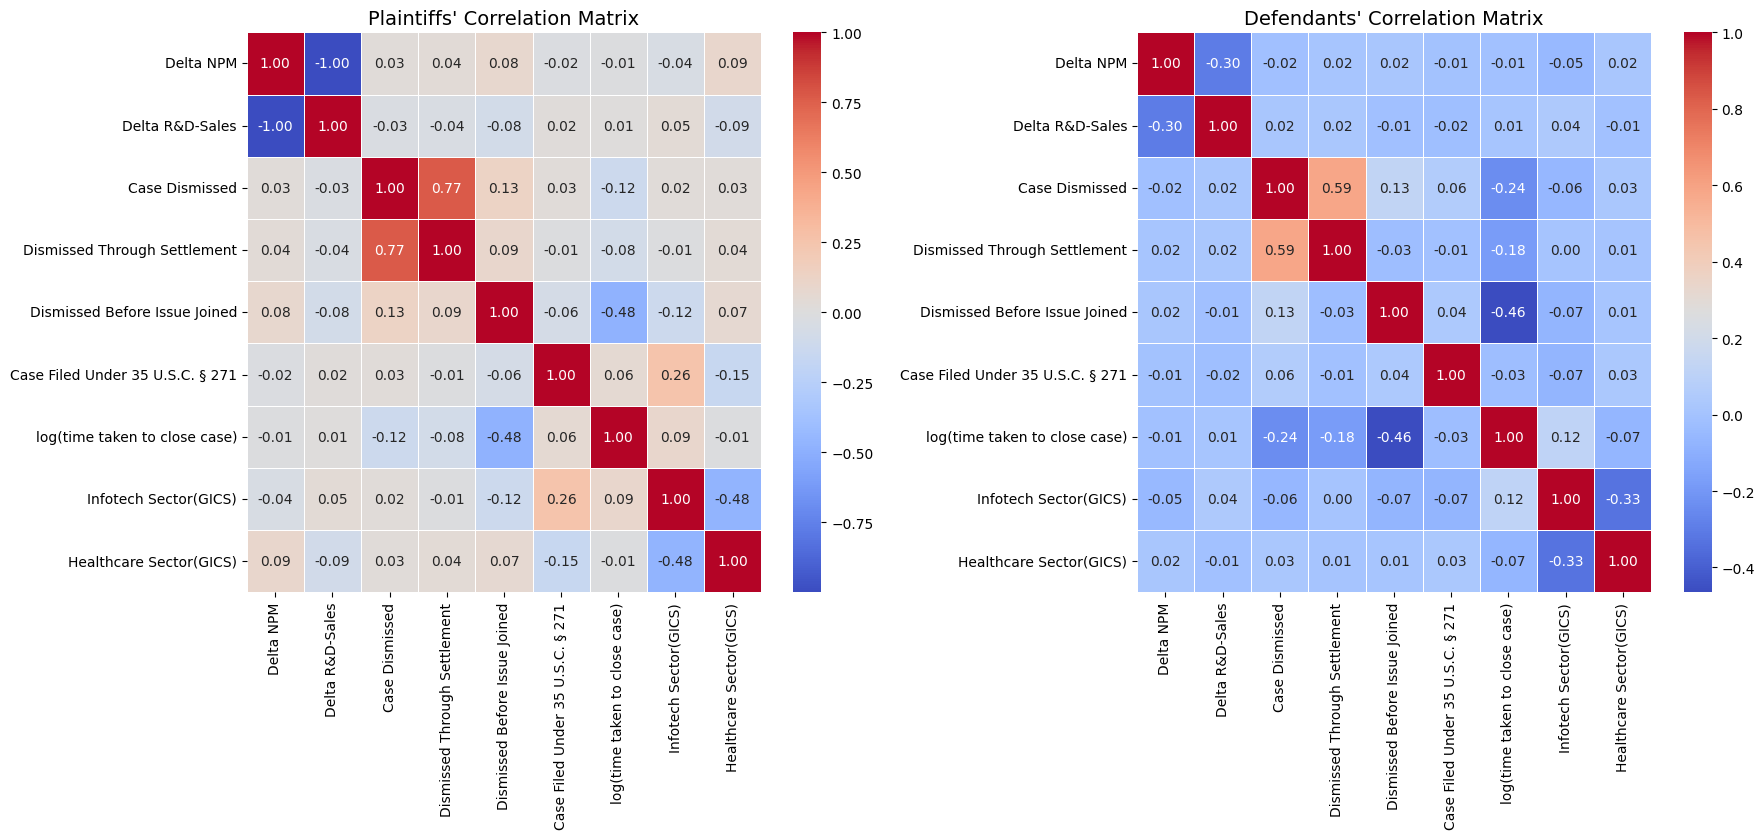

In [110]:
# Compute correlation matrices
corr_matrix_plt = plaintiffs_complete[[
    'delta_npm', 'delta_rnd_sales', 'disp_dismissed', 'disp_settled',
    'disp_before_issue_joined', 'infringement_35_271', 'case_length',
    'info_tech', 'health_care'
    ]].corr()
corr_matrix_def = defendents_complete[[
    'delta_npm', 'delta_rnd_sales', 'disp_dismissed', 'disp_settled',
    'disp_before_issue_joined','infringement_35_271', 'case_length',
    'info_tech', 'health_care'
    ]].corr()

# Rename labels using the provided mapping
label_mapping = {
    "delta_npm": "Delta NPM",
    "delta_rnd_sales": "Delta R&D-Sales",
    "disp_dismissed": "Case Dismissed",
    "disp_settled": "Dismissed Through Settlement",
    "disp_before_issue_joined": "Dismissed Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to close case)",
    "info_tech": "Infotech Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)"
}

# Apply clean labels
corr_matrix_plt = corr_matrix_plt.rename(columns=label_mapping, index=label_mapping)
corr_matrix_def = corr_matrix_def.rename(columns=label_mapping, index=label_mapping)

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))  # Increase size for clarity

# Plot for Plaintiffs
sns.heatmap(corr_matrix_plt, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title("Plaintiffs' Correlation Matrix", fontsize=14)
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability
axes[0].tick_params(axis='y', rotation=0)   # Keep y-axis labels straight

# Plot for Defendants
sns.heatmap(corr_matrix_def, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title("Defendants' Correlation Matrix", fontsize=14)
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()

The Correlation Matricies show, similar small and negative correlations between the variables. These figures also illustrate the disparities between plaintiffs and defendants.

The only highly strong correlation is between the plaintiffs Profits and R&D investment(real value is about 0.992, rounded up by python). This seems to suggest that the plaintiff firms are systematically different from defendents in the sensse that they invest heavily in research to the detriment of their profitability.

The corrleation between dismissals and dismissals with settlement is expected as only cases that are dismissed can involve settlements. Therefore, this relationship is definitional. The dummies for info-tech and healthcare are also correlated simply because they are mutually exclusive categories.

Plaintffs seem to have small, positive correlations and some small negative correlations between the profit/R&D and litigation outcomes.
Defendants on the other hand only have small negative correlations. This is also expected as defendants, having been accused of patent rights violations, have more to lose than the party that brings legal action.


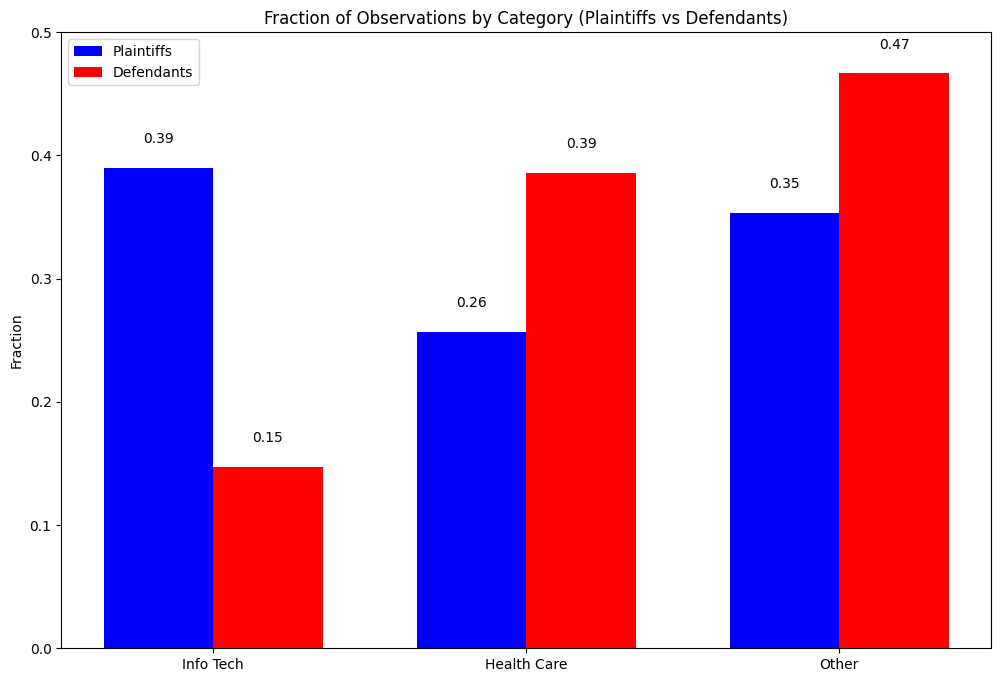

In [111]:
# Function to calculate fractions
def calculate_fractions(df):
    info_tech_count = df['info_tech'].sum()
    health_care_count = df['health_care'].sum()
    total_count = len(df)
    other_count = total_count - (info_tech_count + health_care_count)

    return [info_tech_count / total_count, health_care_count / total_count, other_count / total_count]

# Calculate fractions for both datasets
plaintiffs_fractions = calculate_fractions(plaintiffs_complete)
defendents_fractions = calculate_fractions(defendents_complete)

# Bar chart settings
categories = ['Info Tech', 'Health Care', 'Other']
x = np.arange(len(categories))  # X locations
width = 0.35  # Width of bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot bars
bars1 = ax.bar(x - width/2, plaintiffs_fractions, width, label='Plaintiffs', color='blue')
bars2 = ax.bar(x + width/2, defendents_fractions, width, label='Defendants', color='red')

# Labels, Title, and Legend
ax.set_ylabel('Fraction')
ax.set_title('Fraction of Observations by Category (Plaintiffs vs Defendants)')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Show values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center', fontsize=10)

# Show plot
ax.set_ylim(0, 0.5)
plt.show()

This plot illustrates the differences between the plaintiff and defendent firms, in terms of the sectors that they operate in.

Plaintiffs appear to have the highest concentration of IT firms, followed by Healthcare and the reference category.

The Defendants on the other hand have a higher concentration of the other, followed by health care and IT.

We only explicitly included IT and Healthcare categories because overall, these two categories had considerably more occurrences in the dataset, compared to other sectors. Thus, we only account for fixed effects of IT and Healthcare sectors while also reducing multi-collinearity by having too many dummies for the same category.

# ***Section 5: The Message:***

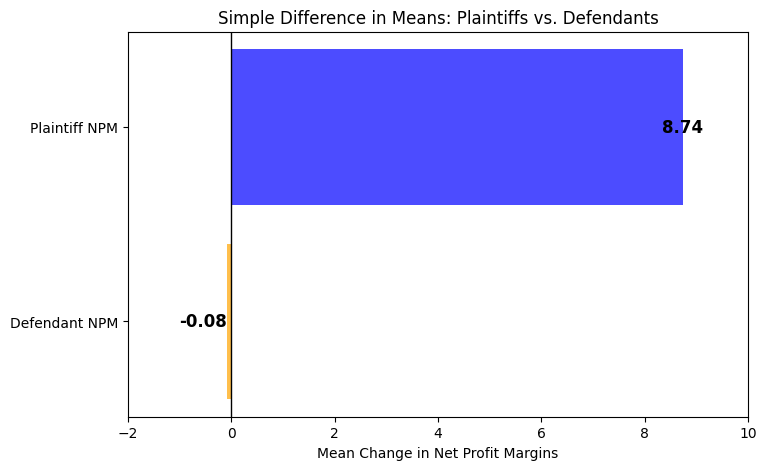

In [112]:
# Compute means
mean_plaintiff = plaintiffs_complete["delta_npm"].mean()
mean_defendant = defendents_complete["delta_npm"].mean()

# Define categories and means
categories = ["Defendant NPM", "Plaintiff NPM"]  # Defendant first so negative is on the left
means = [mean_defendant, mean_plaintiff]  # Order matters!

# Create the horizontal bar plot
plt.figure(figsize=(8, 5))
plt.barh(categories, means, color=["orange", "blue"], alpha=0.7)

# Annotate mean values on bars
for i, mean in enumerate(means):
    plt.text(mean, i, f"{mean:.2f}", ha="center" if mean > 0 else "right",
             va="center", fontsize=12, fontweight="bold", color="black")

# Improve readability
plt.axvline(0, color="black", linewidth=1)  # Add vertical line at x=0 for reference
plt.xlabel("Mean Change in Net Profit Margins")
plt.title("Simple Difference in Means: Plaintiffs vs. Defendants")
plt.xlim(-2,10)

# Show plot
plt.show()


**The Message:** Significant disparities exist between firms that sue over patent rights and firms that are being sued.



**Interpretation of the Figure:**
Plaintiffs are observed to have a 874 percentage point increase(0.01 = 1 percent point) in profit margins, on average, whereas Defendents are observed to have a 8 percentage point decrease in their profit margins, on average. This effectively summarizes the existance of disparities; Plaintiffs that bring legal action based on patent rights, tend to profit significantly while defendents are observed to have declined profitability.

# ***Section 6: Maps:***

In [113]:
#loading up a precleaned gdf to reduce amount of cleaning code displayedx
map_gdf = gpd.read_file('/content/drive/My Drive/ECO225_Final_Project/DATA/cleaned_data.gpkg')

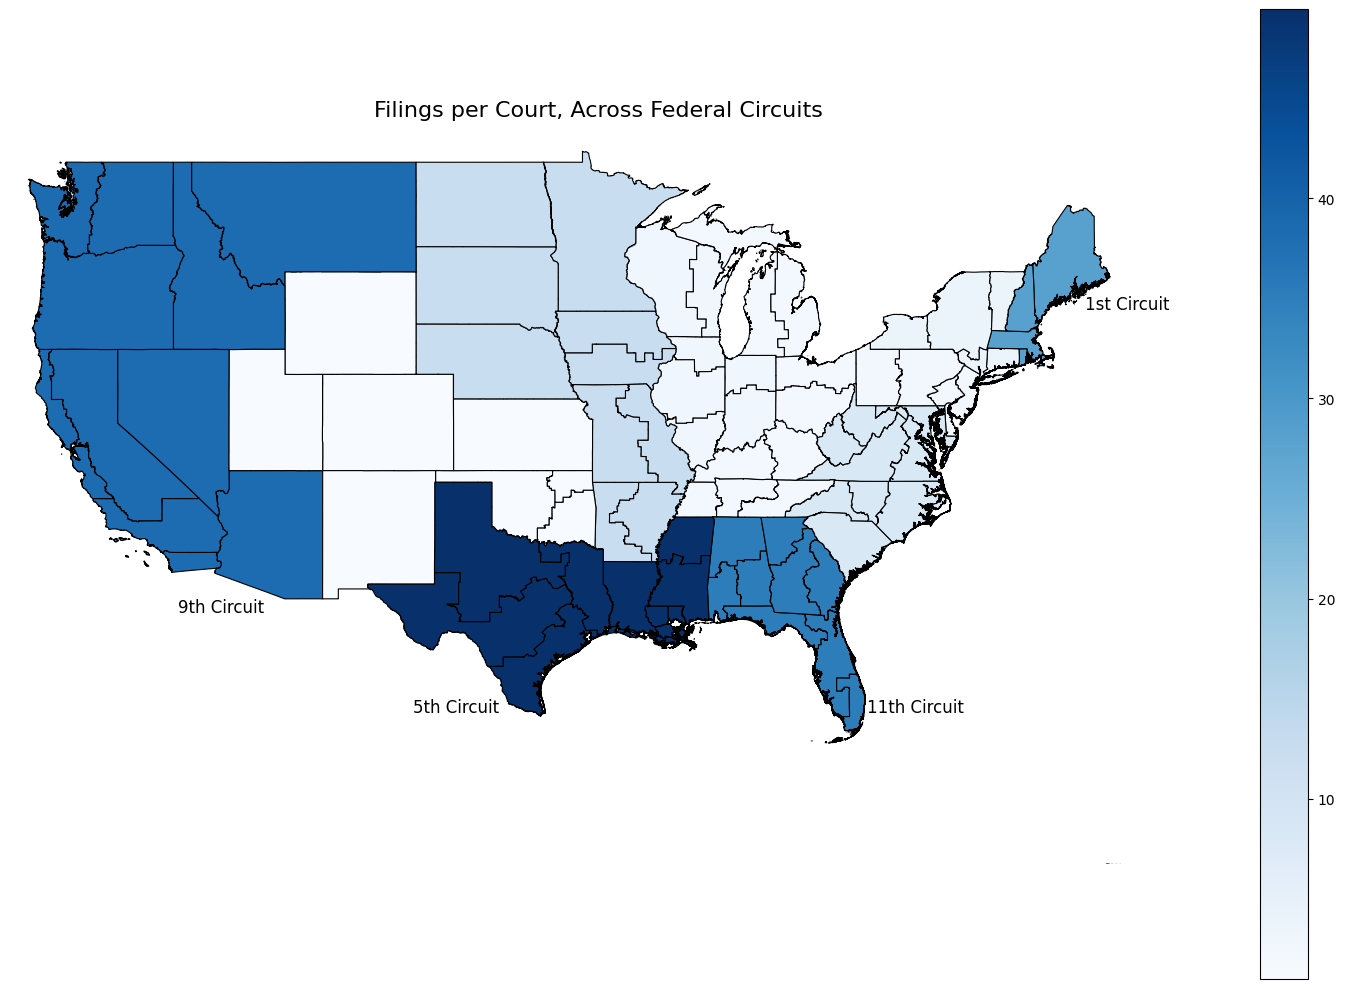

In [114]:
fig, ax = plt.subplots(figsize=(15, 10))

map_gdf.plot(column="filings_per_court",
             cmap="Blues",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             ax=ax)

ax.set_title("Filings per Court, Across Federal Circuits", fontsize=16)
ax.axis("off")  # Hide axis labels
ax.set_xlim([-1.4e7, -7e6])
ax.set_ylim([2.1e6, 6.5e6])

ax.annotate("5th Circuit", xy=(-1.16e7, 3e6), fontsize=12, color='black')
ax.annotate("11th Circuit", xy=(-0.89e7, 3e6), fontsize=12, color='black')
ax.annotate("9th Circuit", xy=(-1.3e7, 3.6e6), fontsize=12, color='black')
ax.annotate("1st Circuit", xy=(-0.76e7, 5.4e6), fontsize=12, color='black')

plt.tight_layout()
plt.show()

The map above portrays the number of case filings per court inside each of the 11 Federal Court Circuits of the Continental United States. We only focus at the 1st, 5th, 9th and 11th circuits, which are all identified with labels and a specific shade of blue that corresponds to filings per court within each circuit.

We observe that for patent suits involving publicly listed companies, the 5th circuit has the highest concentration of filings, followed by the 11th, 9th and the 1st respectively. This hints at potential circuit fixed-effects, such as perceived judge leniency or circuit specific practices that could useful to factor in, at a later stage.

In [115]:
#Manually Mapping out the number codes into district court names for merging :(
court_mapping = {
    "00": "Maine District Court",
    "01": "Massachusetts District Court",
    "02": "New Hampshire District Court",
    "03": "Rhode Island District Court",
    "04": "Puerto Rico District Court",
    "05": "Connecticut District Court",
    "06": "New York Northern District Court",
    "07": "New York Eastern District Court",
    "08": "New York Southern District Court",
    "09": "New York Western District Court",
    "10": "Vermont District Court",
    "11": "Delaware District Court",
    "12": "New Jersey District Court",
    "13": "Pennsylvania Eastern District Court",
    "14": "Pennsylvania Middle District Court",
    "15": "Pennsylvania Western District Court",
    "16": "Maryland District Court",
    "17": "North Carolina Eastern District Court",
    "18": "North Carolina Middle District Court",
    "19": "North Carolina Western District Court",
    "20": "South Carolina District Court",
    "22": "Virginia Eastern District Court",
    "23": "Virginia Western District Court",
    "24": "West Virginia Northern District Court",
    "25": "West Virginia Southern District Court",
    "26": "Alabama Northern District Court",
    "27": "Alabama Middle District Court",
    "28": "Alabama Southern District Court",
    "29": "Florida Northern District Court",
    "3A": "Florida Middle District Court",
    "3C": "Florida Southern District Court",
    "3E": "Georgia Northern District Court",
    "3G": "Georgia Middle District Court",
    "3J": "Georgia Southern District Court",
    "3L": "Louisiana Eastern District Court",
    "3N": "Louisiana Middle District Court",
    "36": "Louisiana Western District Court",
    "37": "Mississippi Northern District Court",
    "38": "Mississippi Southern District Court",
    "39": "Texas Northern District Court",
    "40": "Texas Eastern District Court",
    "41": "Texas Southern District Court",
    "42": "Texas Western District Court",
    "43": "Kentucky Eastern District Court",
    "44": "Kentucky Western District Court",
    "45": "Michigan Eastern District Court",
    "46": "Michigan Western District Court",
    "47": "Ohio Northern District Court",
    "48": "Ohio Southern District Court",
    "49": "Tennessee Eastern District Court",
    "50": "Tennessee Middle District Court",
    "51": "Tennessee Western District Court",
    "52": "Illinois Northern District Court",
    "53": "Illinois Central District Court",
    "54": "Illinois Southern District Court",
    "55": "Indiana Northern District Court",
    "56": "Indiana Southern District Court",
    "57": "Wisconsin Eastern District Court",
    "58": "Wisconsin Western District Court",
    "60": "Arkansas Eastern District Court",
    "61": "Arkansas Western District Court",
    "62": "Iowa Northern District Court",
    "63": "Iowa Southern District Court",
    "64": "Minnesota District Court",
    "65": "Missouri Eastern District Court",
    "66": "Missouri Western District Court",
    "67": "Nebraska District Court",
    "68": "North Dakota District Court",
    "69": "South Dakota District Court",
    "70": "Arizona District Court",
    "71": "California Northern District Court",
    "72": "California Eastern District Court",
    "73": "California Central District Court",
    "74": "California Southern District Court",
    "75": "Hawaii District Court",
    "76": "Idaho District Court",
    "77": "Montana District Court",
    "78": "Nevada District Court",
    "79": "Oregon District Court",
    "80": "Washington Eastern District Court",
    "81": "Washington Western District Court",
    "82": "Colorado District Court",
    "83": "Kansas District Court",
    "84": "New Mexico District Court",
    "85": "Oklahoma Northern District Court",
    "86": "Oklahoma Eastern District Court",
    "87": "Oklahoma Western District Court",
    "88": "Utah District Court",
    "89": "Wyoming District Court",
    "90": "District of Columbia District Court",
    "91": "Virgin Islands District Court",
    "92": "Guam District Court",
    "94": "Northern Mariana Islands District Court",
    "-8": None  # Missing value
}



circuit_mapping = {
    "0": "District of Columbia Circuit",
    "01": "First Circuit",
    '02': "Second Circuit",
    '03': "Third Circuit",
    '04': "Fourth Circuit",
    '05': "Fifth Circuit",
    '06': "Sixth Circuit",
    '07': "Seventh Circuit",
    '08': "Eighth Circuit",
    '09': "Ninth Circuit",
    '10': "Tenth Circuit",
    '11': "Eleventh Circuit",
    'DC': "District of Columbia Circuit",
    '-8': None  # Missing value case
}


merged_cases_FJC["DISTRICT"] = merged_cases_FJC["DISTRICT"].astype(str).map(court_mapping)

In [116]:
#plotting average dismissals/court by Circuits
map_disposals = merged_cases_FJC.groupby("DISTRICT").agg({
    "disp_dismissed": "sum",
    "disp_settled": "sum",
    "disp_before_issue_joined": "sum"})

map_disposals = map_disposals.reset_index()
map_gdf = pd.merge(map_gdf, map_disposals, left_on="NAME" ,right_on="DISTRICT", how="left")

map_gdf['circuit_dismissed'] = map_gdf.groupby("Circuit")["disp_dismissed"].transform('sum')
map_gdf['dismissals_per_court'] = map_gdf['circuit_dismissed']/map_gdf['num_district_courts']

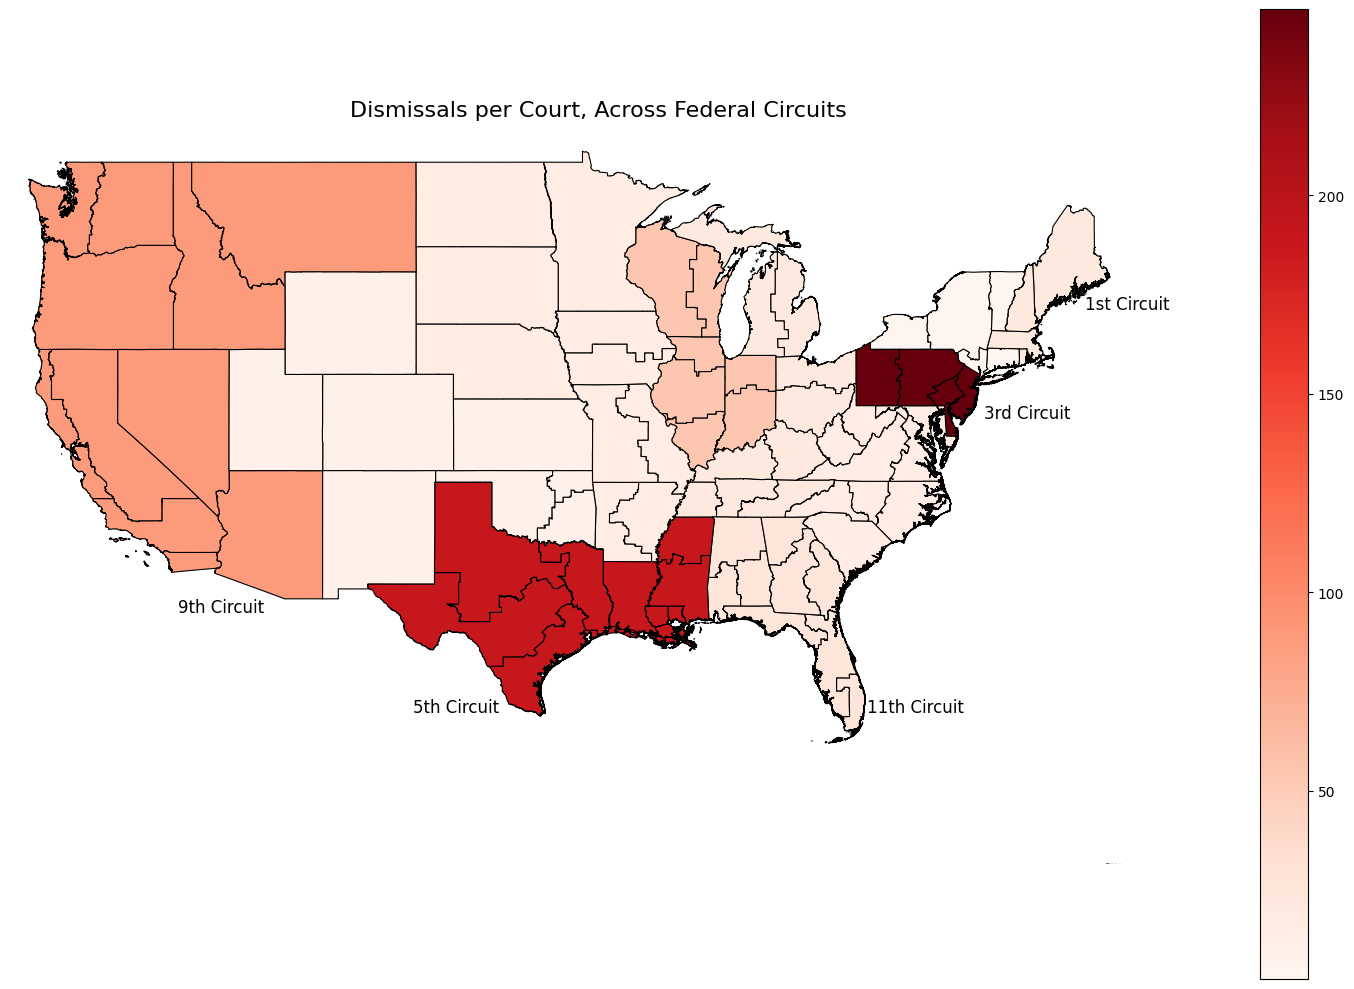

In [117]:
fig, ax = plt.subplots(figsize=(15, 10))

map_gdf.plot(column="dismissals_per_court",
             cmap="Reds",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             ax=ax)

ax.set_title("Dismissals per Court, Across Federal Circuits", fontsize=16)
ax.axis("off")  # Hide axis labels
ax.set_xlim([-1.4e7, -7e6])
ax.set_ylim([2.1e6, 6.5e6])

ax.annotate("5th Circuit", xy=(-1.16e7, 3e6), fontsize=12, color='black')
ax.annotate("11th Circuit", xy=(-0.89e7, 3e6), fontsize=12, color='black')
ax.annotate("9th Circuit", xy=(-1.3e7, 3.6e6), fontsize=12, color='black')
ax.annotate("1st Circuit", xy=(-0.76e7, 5.4e6), fontsize=12, color='black')
ax.annotate("3rd Circuit", xy=(-0.82e7, 4.75e6), fontsize=12, color='black')


plt.tight_layout()
plt.show()

This map shows the number of Dismissals per court. Interstingly, even though the 3rd circuit, previously did not appear to have a significant number of case filings per court, it has the highest concentration of dismissals. The 3rd circuit is followed by 5th, 9th, 11th and the 1st circuits.

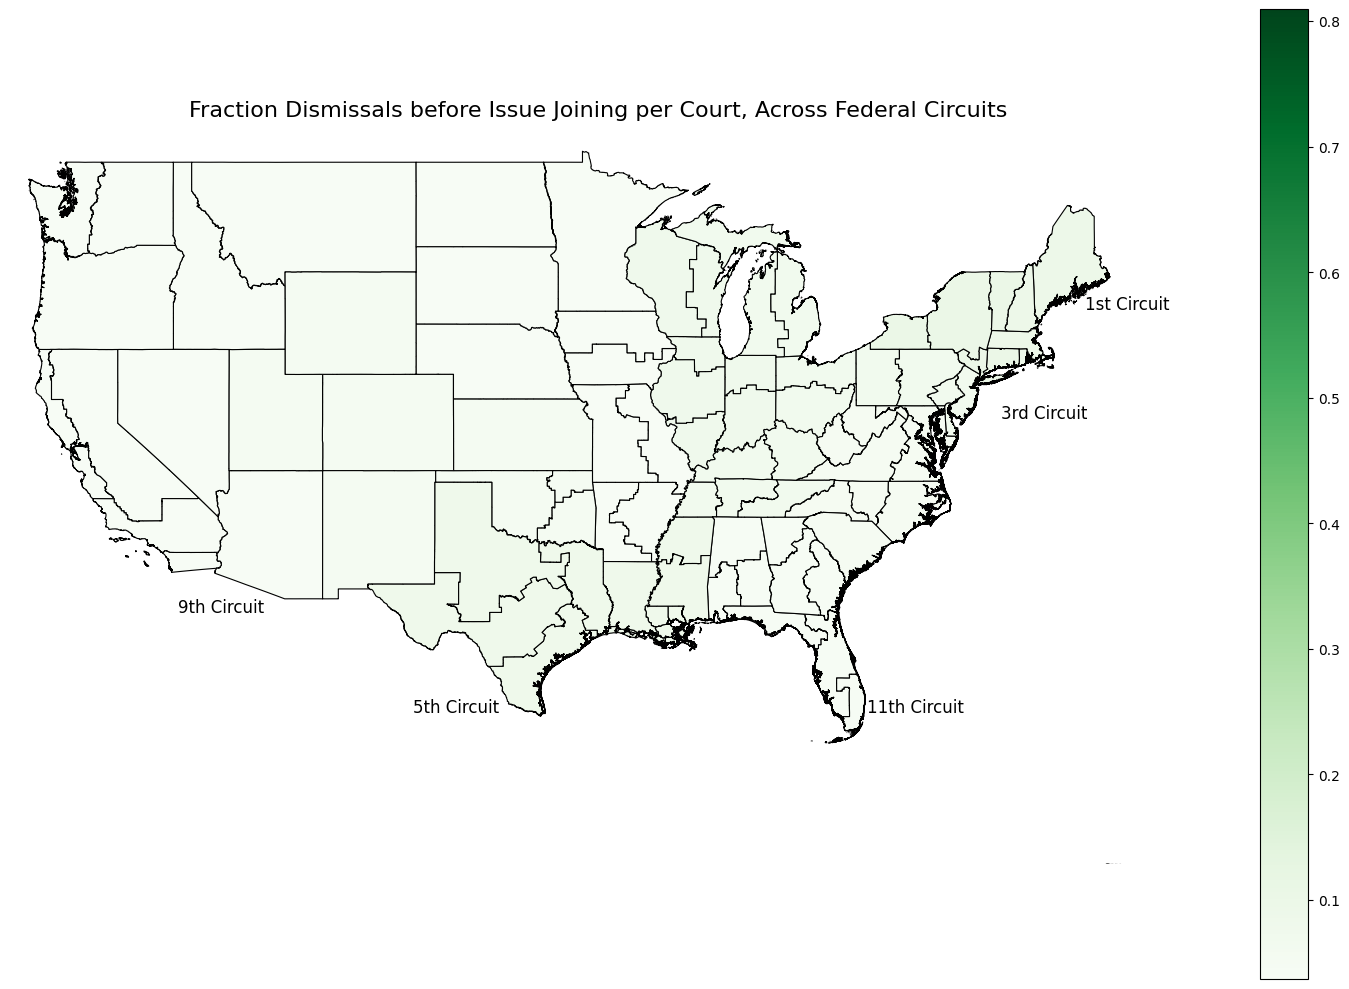

In [118]:
map_gdf['circuit_disp_issue_joined'] = map_gdf.groupby("Circuit")["disp_before_issue_joined"].transform('sum')
map_gdf['dismissals_before_issue'] = (map_gdf['circuit_disp_issue_joined']/map_gdf['circuit_dismissed'])/map_gdf['num_district_courts']

fig, ax = plt.subplots(figsize=(15, 10))

map_gdf.plot(column="dismissals_before_issue",
             cmap="Greens",
             linewidth=0.8,
             edgecolor="black",
             legend=True,
             ax=ax)

ax.set_title("Fraction Dismissals before Issue Joining per Court, Across Federal Circuits", fontsize=16)
ax.axis("off")  # Hide axis labels
ax.set_xlim([-1.4e7, -7e6])
ax.set_ylim([2.1e6, 6.5e6])

ax.annotate("5th Circuit", xy=(-1.16e7, 3e6), fontsize=12, color='black')
ax.annotate("11th Circuit", xy=(-0.89e7, 3e6), fontsize=12, color='black')
ax.annotate("9th Circuit", xy=(-1.3e7, 3.6e6), fontsize=12, color='black')
ax.annotate("1st Circuit", xy=(-0.76e7, 5.4e6), fontsize=12, color='black')
ax.annotate("3rd Circuit", xy=(-0.81e7, 4.75e6), fontsize=12, color='black')


plt.tight_layout()
plt.show()

This map shows the Fraction of Dismissals before issue joining, per court in each circuit. This map shows a very uniform geographical distribution, with no circuit appearing to have a significantly different rate of dismissals before issue joining per court.

# ***Section 7: Regressions:***

In [119]:
# Regression Table 1.1: The imapct of Case Disposals on Net Profit Margins[Defendents]

#base model
model1_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_defendent_npm).fit()
#includes interactions
model2_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined', data=subset_defendent_npm).fit()
#includes interactions and case cause and length
model3_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_defendent_npm).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_defendent_npm).fit()


#The imapct of Case Disposals on Net Profit Margins[Plaintiffs]

#based model
model1_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_plaintiff_npm).fit()
#includes interactions
model2_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined', data=subset_plaintiff_npm).fit()
#includes interactions and case cause and length
model3_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_plaintiff_npm).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_plaintiff_npm).fit()


#creating stargazer object
stargazer = Stargazer([model1_d, model2_d, model3_d, model4_d,
                       model1_p, model2_p, model3_p, model4_p])

# Custom column names
stargazer.custom_columns([
    "Defendant Model 1", "Defendant Model 2", "Defendant Model 3", "Defendant Model 4",
    "Plaintiff Model 1", "Plaintiff Model 2", "Plaintiff Model 3", "Plaintiff Model 4",
], [1, 1, 1, 1, 1, 1, 1, 1])

# Force variable order to match model specification
stargazer.covariate_order(["Intercept", "disp_dismissed", "disp_dismissed:disp_settled",
                            "disp_dismissed:disp_before_issue_joined",
                           "disp_dismissed:disp_settled:disp_before_issue_joined",
                           "infringement_35_271",
                            "case_length", "info_tech", "health_care"])

stargazer.rename_covariates({
    "disp_dismissed": "Case Dismissed",
    "disp_dismissed:disp_settled": "Dismissed:Settlement",
    "disp_dismissed:disp_before_issue_joined": "Dismissed:Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to cose case)",
    "info_tech": "Information Technology Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)",
    "disp_dismissed:disp_settled:disp_before_issue_joined":"Dismissed:Before Issue Joined:Settlement"})

stargazer.title("Esimated effect of Case Outcomes on Plaintiff Firms' Net Profit Margins")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))


Model Specifications:
* Model1: delta_npm = Intercetpt + Case_Dismised + Case_Dismissed:Dismissed_with_Settlement

* Model2: delta_npm = Intercetpt + Case_Dismised + Case_Dismissed:Dismissed_with_Settlement + Case_Dismised:Dismissed_Before_Issue_Joined

* Model3: delta_npm = Intercetpt + Case_Dismised + Case_Dismissed:Dismissed_with_Settlement + Case_Dismised:Dismissed_Before_Issue_Joined + Filed_under_35:271 + log(days_taken)

* Model4: delta_npm = Intercetpt + Case_Dismised + Case_Dismissed*Dismissed_with_Settlement + Case_Dismised*Dismissed_Before_Issue_Joined + Filed_under_35:271 + log(days_taken) + Info_Tech + Health_Care

Models 1 to 3 are all subsets of model 4, with R-squarred and Adj. R-squarred values, we observe that model 4 is the best, in terms of explainging variance in the outcome variables. We also note that since the outcome variables are differences in a percent points(on the scale of 0.01 = 1 percent point), our Betas are also part of the same scale of percent point differences, which makes interpretation convenient.

The first regression table shows the results of litigation impacts on Net Profit Margins for Defendants and Plaintiffs. While a lot of the coefficients and F-statistics appear to not be statistically significant, there are some very interesting key findings.

For the Defendants:
*   We observe that Case Dismissals, as opposed to a full fledged legal battle ended by a final judgment, on average are associated with a 46 perecentage point decrease in Profit Margins(holding constant covariates), significant at the 95% confidennce level. This is surprising as the general intuition regarding dismissals is that they save firms money, by avoiding expensive, longterm litigation.   

*   We also observe that the dismissals through settlements, have a positive interaction effect of 30 percentage point increase, which brings the net effect to about a 16 percentage point decrease in Profit Margins(holding constant covariates), significant at the 90% level. This alligns with intuition as settlements are likely to be sealed from public records and have stipulations that give the defendants certain protections like safety from being sued again over the same issue, thus settlements are observed to be mitigating some of the negative impact of dismissals.

*   In addition, we observe that firms in the Information Technology sector are specifically are observed to have about a 49 percentage point decrease in Net Profit Margins(holding constant covariates), after being sued for patent related matters. This is significant at the 90% confidence level. When the case goes to judgment the net effect is still 49 percentage points, but with dismissals, the net effect becomes a 95 percentage point decrease in Profit Margins, which is also really surp

For the Plaintiffs:

* For plaintiffs, we find a highly surprising surge Profit Margings of firms that have their cases dismissed before issue joining. On avearge, these plaintiff firms have a 4000 percentage points increase in Profit Margins(holding constant covariates), this is also significant at 99% level. This is extremely surpising for two reasons; the first being the size of the effect and the second being the direction. A 4000 percent point increase is simply mind boggling, especially considering the fact, that the general intuition about dismissals is that they facour defendants. While it is possible that dismissals can include settlements or other agreements that are favourable to plaintiffs, it is still amazing to see that they are observed with such extreme surges in profits.
* Additionally, we find that firms in the healthcare sector, specicifally, are observed to have 3500 percentage point increase in profits,significant at the 9, when cases go the judgement. With dismissals, the net effect is 7500 percentage point increase profit margins, which is really surprising.







In [120]:
# Regression Table 2.1: The imapct of Case Disposals on RnD-Sales Ratio[Defendent]

#base model
model1_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_defendent_RnD).fit()
#includes interactions
model2_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined', data=subset_defendent_RnD).fit()
#includes interactions and case cause
model3_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_defendent_RnD).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_defendent_RnD).fit()


# Regression Table 2.2: The imapct of Case Disposals on RnD-Sales Ratio[Plaintiffs]

#based model
model1_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled', data=subset_plaintiff_RnD).fit()
#includes interactions
model2_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined', data=subset_plaintiff_RnD).fit()
#includes interactions and case cause
model3_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length', data=subset_plaintiff_RnD).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + disp_dismissed:disp_settled:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care', data=subset_plaintiff_RnD).fit()


#creating stargazer object
stargazer = Stargazer([model1_d, model2_d, model3_d, model4_d,
                       model1_p, model2_p, model3_p, model4_p])

# Custom column names
stargazer.custom_columns([
    "Defendant Model 1", "Defendant Model 2", "Defendant Model 3", "Defendant Model 4",
    "Plaintiff Model 1", "Plaintiff Model 2", "Plaintiff Model 3", "Plaintiff Model 4",
], [1, 1, 1, 1, 1, 1, 1, 1])

# Force variable order to match model specification
stargazer.covariate_order(["Intercept", "disp_dismissed", "disp_dismissed:disp_settled",
                            "disp_dismissed:disp_before_issue_joined",
                            "disp_dismissed:disp_settled:disp_before_issue_joined",
                           "infringement_35_271",
                            "case_length",  "info_tech", "health_care"])

stargazer.rename_covariates({
    "disp_dismissed": "Case Dismissed",
    "disp_dismissed:disp_settled": "Dismissed:Settlement",
    "disp_dismissed:disp_before_issue_joined": "Dismissed:Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to cose case)",
    "info_tech": "Information Technology Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)",
    "disp_dismissed:disp_settled:disp_before_issue_joined":"Dismissed:Before Issue Joined:Settlement"})

stargazer.title("Esimated effect of Case Outcomes on Plaintiff Firms' Change in R&D to Sales Ratio")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))

The second Regression table has the same model specifications, with the only difference being the difference in R&D to sales ratio is the outcome variable. Overall, most of the estimated coefficients appear to be statistically insignificant with the exception info-tech defendants and healthcare plaintiffs.

Info-Tech Defendants:
* We observe 7.7 percentage point increase in R&D investment for firms in the info-tech sector, significant at the 90% level. This is surprising, as it suggests that being sued encourages investment in research.

Healthcare Plaintiffs:
* We observe a massive 1100 percentage point drop in research investment for plaintiffs, significant at the 90% level. This is also really counterituitive as it suggests the suing another firm makes the plaintiff disincitivized to invest in research, which if true, is a significant negative externality to society.

Needless to say, all estiamted effects between the two regression tables are simply observed realtionships and not causal in nature. Any number of observable or latent factors could be influencing these factors, thus futher work on valid causal inference would be key, with regards to better understanding the impact of litigation outcomes.

# ***Section 8: Web Scraping***




In [121]:
patents = pd.read_csv("/content/drive/My Drive/ECO225_Final_Project/DATA/patents.csv")
defendents_complete = defendents_complete.merge(patents[['case_number', 'patent']], on='case_number', how ='left')
plaintiffs_complete = plaintiffs_complete.merge(patents[['case_number', 'patent']], on='case_number', how ='left')

In [122]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
import aiohttp
from bs4 import BeautifulSoup
import time

async def fetch(session, url):
    headers = {"User-Agent": "Mozilla/5.0 (compatible; PatentScraper/1.0)"}
    try:
        async with session.get(url, headers=headers) as response:
            if response.status == 200:
                return await response.text()
            else:
                print(f"Error {response.status} for URL: {url}")
                return None
    except Exception as e:
        print(f"Exception for URL: {url}: {e}")
        return None

async def scrape_patent_info(session, patent_number):
    url = f"https://patents.google.com/patent/US{patent_number}/en"
    html = await fetch(session, url)
    if not html:
        print(f"Failed to retrieve patent {patent_number}")
        return None

    soup = BeautifulSoup(html, 'html.parser')

    # Extract Patent Title
    title_tag = soup.find("meta", {"name": "DC.title"})
    title = title_tag.get("content") if title_tag else None

    # Extract Filing Date
    filing_date_tag = soup.find("meta", {"scheme": "patent.filing_date"})
    filing_date = filing_date_tag.get("content") if filing_date_tag else None

    # Extract Issue Date
    issue_date_tag = soup.find("meta", {"scheme": "patent.issue_date"})
    issue_date = issue_date_tag.get("content") if issue_date_tag else None

    # Extract Assignee
    assignee_tag = soup.find("meta", {"scheme": "patent.assignee"})
    assignee = assignee_tag.get("content") if assignee_tag else None

    # Extract Abstract text (if available)
    abstract_section = soup.find("div", {"class": "abstract"})
    abstract = abstract_section.get_text(separator=" ", strip=True) if abstract_section else None

    # Extract Citation Count (example method)
    cited_by_section = soup.find("section", {"itemprop": "citedBy"})
    if cited_by_section:
        cited_by_count = len(cited_by_section.find_all("tr"))
    else:
        cited_by_count = None

    # Extract Classification Codes
    classification_tag = soup.find("dd", {"itemprop": "ipcSection"})
    classification = classification_tag.get_text(separator=" ", strip=True) if classification_tag else None

    # Extract Claim Count (if provided)
    claim_tag = soup.find("meta", {"name": "DC.relation.claimCount"})
    claim_count = claim_tag.get("content") if claim_tag else None

    return {
        "patent_number": patent_number,
        "title": title,
        "filing_date": filing_date,
        "issue_date": issue_date,
        "assignee": assignee,
        "abstract": abstract,
        "cited_by_count": cited_by_count,
        "classification": classification,
        "claim_count": claim_count
    }

async def main(patent_numbers):
    results = []
    # Limit concurrent connections to avoid overwhelming the target server
    connector = aiohttp.TCPConnector(limit=100)
    async with aiohttp.ClientSession(connector=connector) as session:
        tasks = [asyncio.create_task(scrape_patent_info(session, num)) for num in patent_numbers]
        responses = await asyncio.gather(*tasks)
        results = [r for r in responses if r is not None]
    return results

patent_numbers = list(set(plaintiffs_complete['patent'].dropna()).union(set(defendents_complete['patent'].dropna())))
scraped_data = await main(patent_numbers)
scraped_df = pd.DataFrame(scraped_data)

Streaming output truncated to the last 5000 lines.
Exception for URL: https://patents.google.com/patent/US7890648/en: 
Failed to retrieve patent 7890648
Exception for URL: https://patents.google.com/patent/US10299517/en: 
Failed to retrieve patent 10299517
Exception for URL: https://patents.google.com/patent/US6925481/en: 
Failed to retrieve patent 6925481
Exception for URL: https://patents.google.com/patent/US7867727/en: 
Failed to retrieve patent 7867727
Exception for URL: https://patents.google.com/patent/US5940771/en: 
Failed to retrieve patent 5940771
Exception for URL: https://patents.google.com/patent/US9216178/en: 
Failed to retrieve patent 9216178
Exception for URL: https://patents.google.com/patent/US5694322/en: 
Failed to retrieve patent 5694322
Exception for URL: https://patents.google.com/patent/US6895118/en: 
Failed to retrieve patent 6895118
Exception for URL: https://patents.google.com/patent/US6199076/en: 
Failed to retrieve patent 6199076
Exception for URL: https://pa

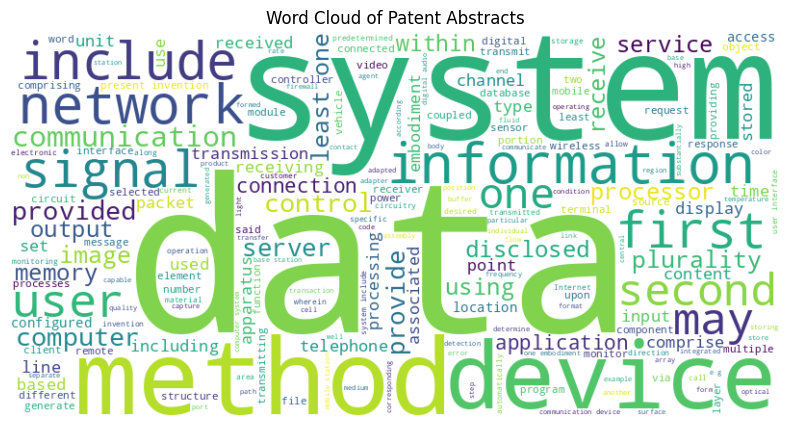

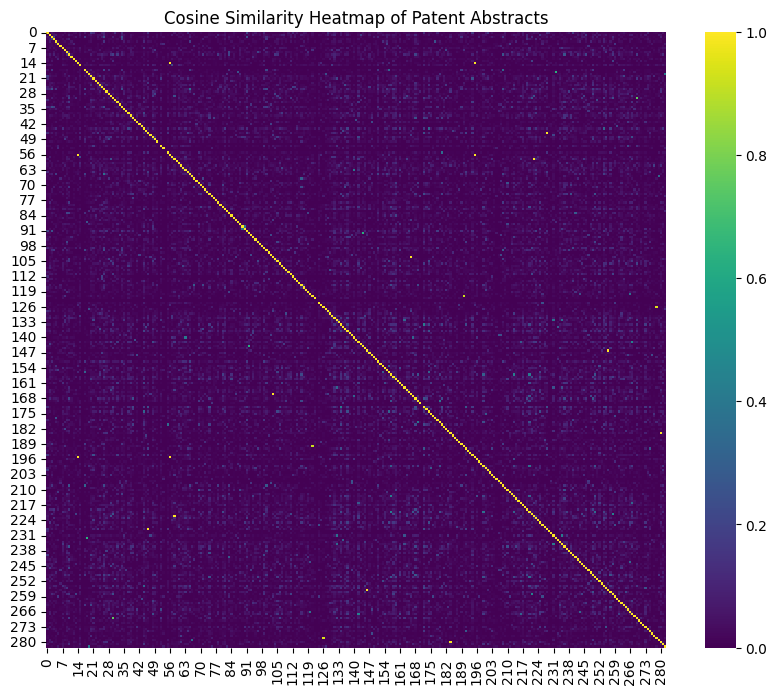

Top similar patent pairs (indices and similarity score):
Patent 103 and Patent 166: 1.000
Patent 46 and Patent 228: 1.000
Patent 58 and Patent 222: 1.000
Patent 146 and Patent 256: 1.000
Patent 14 and Patent 56: 1.000
Patent 14 and Patent 195: 1.000
Patent 56 and Patent 195: 1.000
Patent 184 and Patent 280: 0.992
Patent 126 and Patent 278: 0.952
Patent 121 and Patent 190: 0.923


In [123]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Assume scraped_df is already loaded with a column "abstract"

# Generate Word Cloud
all_text = " ".join(scraped_df["abstract"].dropna())
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Patent Abstracts")
plt.show()

# Compute TF-IDF and Cosine Similarity
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(scraped_df["abstract"].fillna(""))
cos_sim = cosine_similarity(tfidf_matrix)

# Plot Cosine Similarity Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim, cmap='viridis')
plt.title("Cosine Similarity Heatmap of Patent Abstracts")
plt.show()

# Find top similar patent pairs with similarity above threshold
threshold = 0.5
similar_pairs = []
n = cos_sim.shape[0]
for i in range(n):
    for j in range(i + 1, n):
        if cos_sim[i, j] > threshold:
            similar_pairs.append((i, j, cos_sim[i, j]))
similar_pairs = sorted(similar_pairs, key=lambda x: x[2], reverse=True)

print("Top similar patent pairs (indices and similarity score):")
for i, j, score in similar_pairs[:10]:
    print(f"Patent {i} and Patent {j}: {score:.3f}")


In [124]:
scraped_df

,patent_number,title,filing_date,issue_date,assignee,abstract,cited_by_count,classification,claim_count
0,7613267,Digitally-synthesized loop filter method and c...,None,None,None,"In a feedback system such as a PLL, the integr...",None,None,None
1,7353367,System and software for catenated group shift ...,None,None,None,A programmable processor and method for improv...,None,None,None
2,6563187,CMOS image sensor integrated together with mem...,None,None,None,The present invention relates to a CMOS (Compl...,None,None,None
3,7694115,Network-based alert management system \n,None,None,None,A system for managing network alerts including...,None,None,None
4,7921139,System for sequentially opening and displaying...,None,None,None,A system for sequentially opening and displayi...,None,None,None
...,...,...,...,...,...,...,...,...,...
278,7691057,Surgical access system and related methods \n ...,None,None,None,A surgical access system including a tissue di...,None,None,None
279,RE43633,System and method for linking streams of multi...,None,None,None,A system for indexing displayed elements that ...,None,None,None
280,10750151,Method and apparatus for colour imaging a thre...,None,None,None,A device for determining the surface topology ...,None,None,None
281,7383022,Mobile equipment based filtering for packet ra...,None,None,None,A method for operating a mobile equipment (ME ...,None,None,None


In [125]:
scraped_df.isna().sum()

,0
patent_number,0
title,0
filing_date,283
issue_date,283
assignee,283
abstract,5
cited_by_count,283
classification,283
claim_count,283


In [126]:
print("Could only scrape", len(scraped_df), 'pages but the data has',
      len(patent_numbers), 'unique patent numbers')

Could only scrape 283 pages but the data has 4470 unique patent numbers


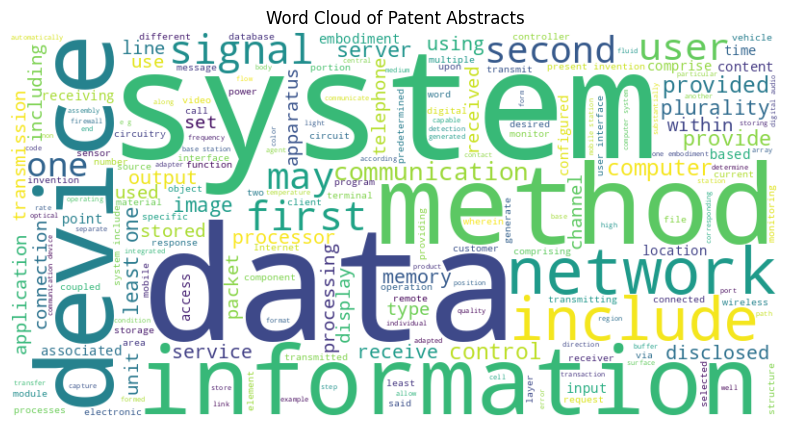

In [127]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Assume scraped_df is already loaded with a column "abstract"

# Generate Word Cloud
all_text = " ".join(scraped_df["abstract"].dropna())
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Patent Abstracts")
plt.show()

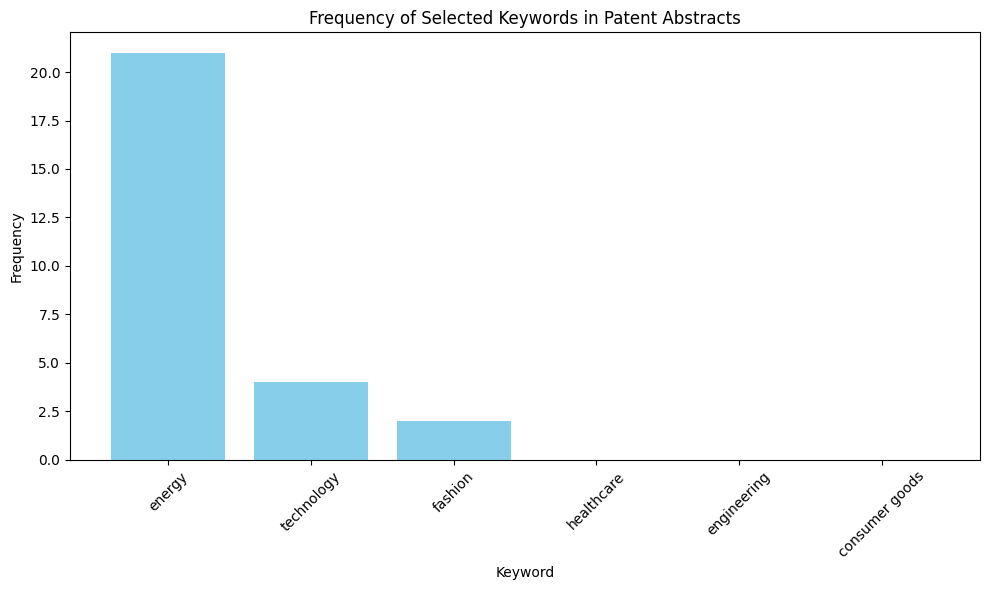

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume scraped_df is already loaded with a column "abstract"
keywords = ["technology", "healthcare", "engineering", "fashion", "consumer goods", "energy"]

# Count occurrences of each keyword in all abstracts (case-insensitive)
frequency = {word: scraped_df["abstract"].str.lower().str.count(word).sum() for word in keywords}

# Create a DataFrame for plotting and sort by frequency
freq_df = pd.DataFrame(list(frequency.items()), columns=["Keyword", "Frequency"]).sort_values("Frequency", ascending=False)

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(freq_df["Keyword"], freq_df["Frequency"], color='skyblue')
plt.xlabel("Keyword")
plt.ylabel("Frequency")
plt.title("Frequency of Selected Keywords in Patent Abstracts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ***Section 9: Machine Learing***

In [175]:
complete_data = pd.concat([plaintiffs_complete, defendents_complete], axis=0)
complete_data = complete_data.drop(columns=['case_number','date_filed','patent', 'PLT'])

complete_data['DEF'] = complete_data['DEF'].notna().astype(int)

In [176]:
complete_data

,delta_npm,delta_rnd_sales,disp_dismissed,disp_settled,disp_before_issue_joined,infringement_35_271,disp_judgment,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,judgment_for_defendent,jury_demand_defendent,jury_demand_both,case_length,info_tech,health_care,materials,consumer_discretionary,DEF
0,-0.056082,0.009418,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,6.588926,0.0,0.0,0.0,0.0,0
1,-0.061502,0.005320,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,4.595120,1.0,0.0,0.0,0.0,0
2,-0.008659,0.017003,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5.225747,0.0,1.0,0.0,0.0,0
3,-0.011065,-0.003862,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,7.451242,0.0,0.0,1.0,0.0,0
4,0.000061,-0.000474,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.025352,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,0.001318,0.000000,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,4.663439,0.0,0.0,0.0,1.0,1
2555,0.332866,-0.004756,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.218600,0.0,0.0,0.0,0.0,1
2556,-0.011602,0.003026,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.484635,0.0,0.0,0.0,0.0,1
2557,0.005629,0.009647,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,6.786717,0.0,1.0,0.0,0.0,1


The objective function of the Regression Trees algorithm is

Mean Squared Error (NPM): 3.925321662309624
R-Squarred (NPM): 0.9998334612106695
Mean Squared Error (R&D)): 43350.45837489908
R-Squarred (R&D): 0.9998334612106695


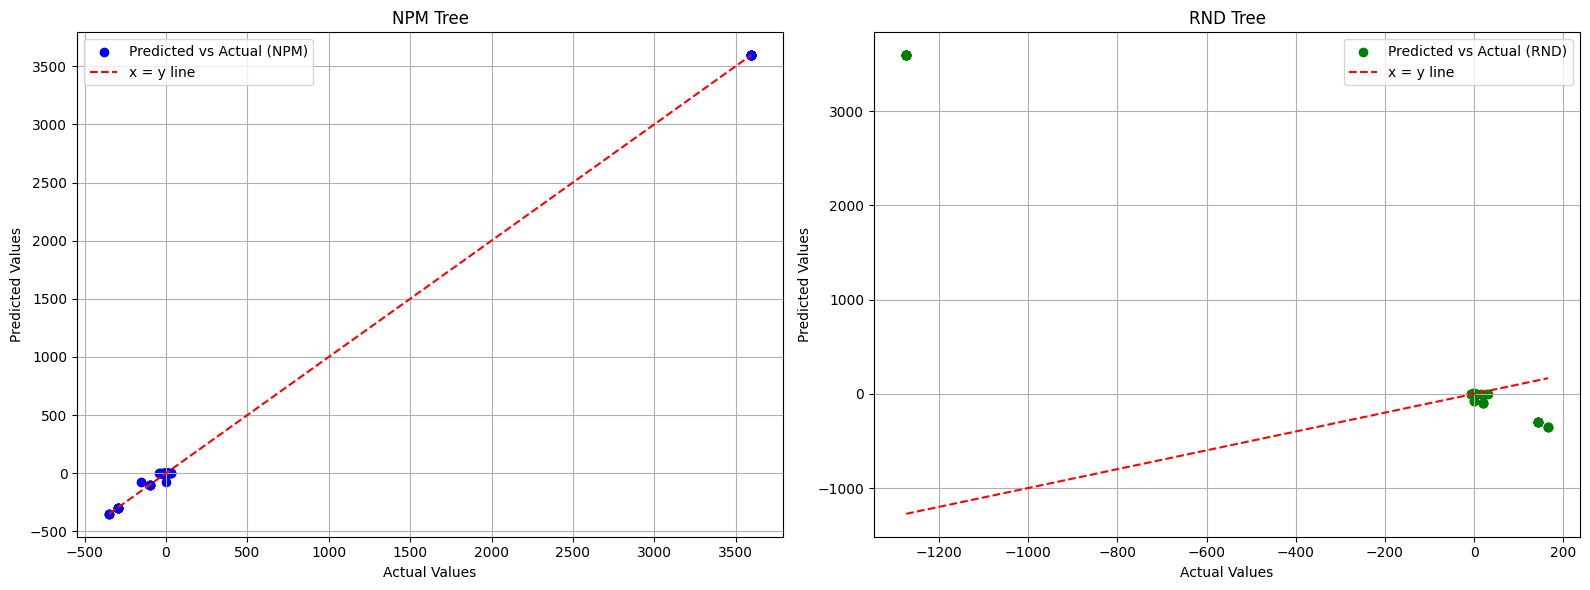

In [177]:
#Running Regression Trees for change in Net Profit Margins with subset of Xs
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

# non-NaN dataset
complete_data = complete_data[complete_data['delta_npm'].notna()]

# Features and target
X_npm = complete_data[['disp_dismissed', 'disp_settled',
                      'disp_before_issue_joined', 'infringement_35_271',
                      'case_length', 'info_tech', 'health_care']]
y_npm = complete_data['delta_npm']

X_rnd = complete_data[['disp_dismissed', 'disp_settled',
                      'disp_before_issue_joined', 'infringement_35_271',
                      'case_length', 'info_tech', 'health_care']]
y_rnd = complete_data['delta_rnd_sales']

# Initialize and train model
npm_regtree = DecisionTreeRegressor(random_state=42, max_depth=5)
npm_regtree.fit(X_npm, y_npm)

rnd_regtree = DecisionTreeRegressor(random_state=42, max_depth=5)
rnd_regtree.fit(X_rnd, y_rnd)


# Predict and evaluate
y_pred_npm = npm_regtree.predict(X_npm)
mse_npm = mean_squared_error(y_npm, y_pred_npm)
r2_npm = r2_score(y_npm, y_pred_npm)

y_pred_rnd = npm_regtree.predict(X_rnd)
mse_rnd = mean_squared_error(y_rnd, y_pred_rnd)
r2_rnd = r2_score(y_npm, y_pred_npm)


print("Mean Squared Error (NPM):", mse_npm)
print("R-Squarred (NPM):", r2_npm)
print("Mean Squared Error (R&D)):", mse_rnd)
print("R-Squarred (R&D):", r2_rnd)


#Plot actual vs predicted with x=y line
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for model 1
axes[0].scatter(y_npm, y_pred_npm, label='Predicted vs Actual (NPM)', color='blue')
axes[0].plot([y_npm.min(), y_npm.max()], [y_npm.min(), y_npm.max()], 'r--', label='x = y line')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('NPM Tree')
axes[0].legend()
axes[0].grid(True)

# Plot for model 2
axes[1].scatter(y_rnd, y_pred_rnd, label='Predicted vs Actual (RND)', color='green')
axes[1].plot([y_rnd.min(), y_rnd.max()], [y_rnd.min(), y_rnd.max()], 'r--', label='x = y line')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('RND Tree')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

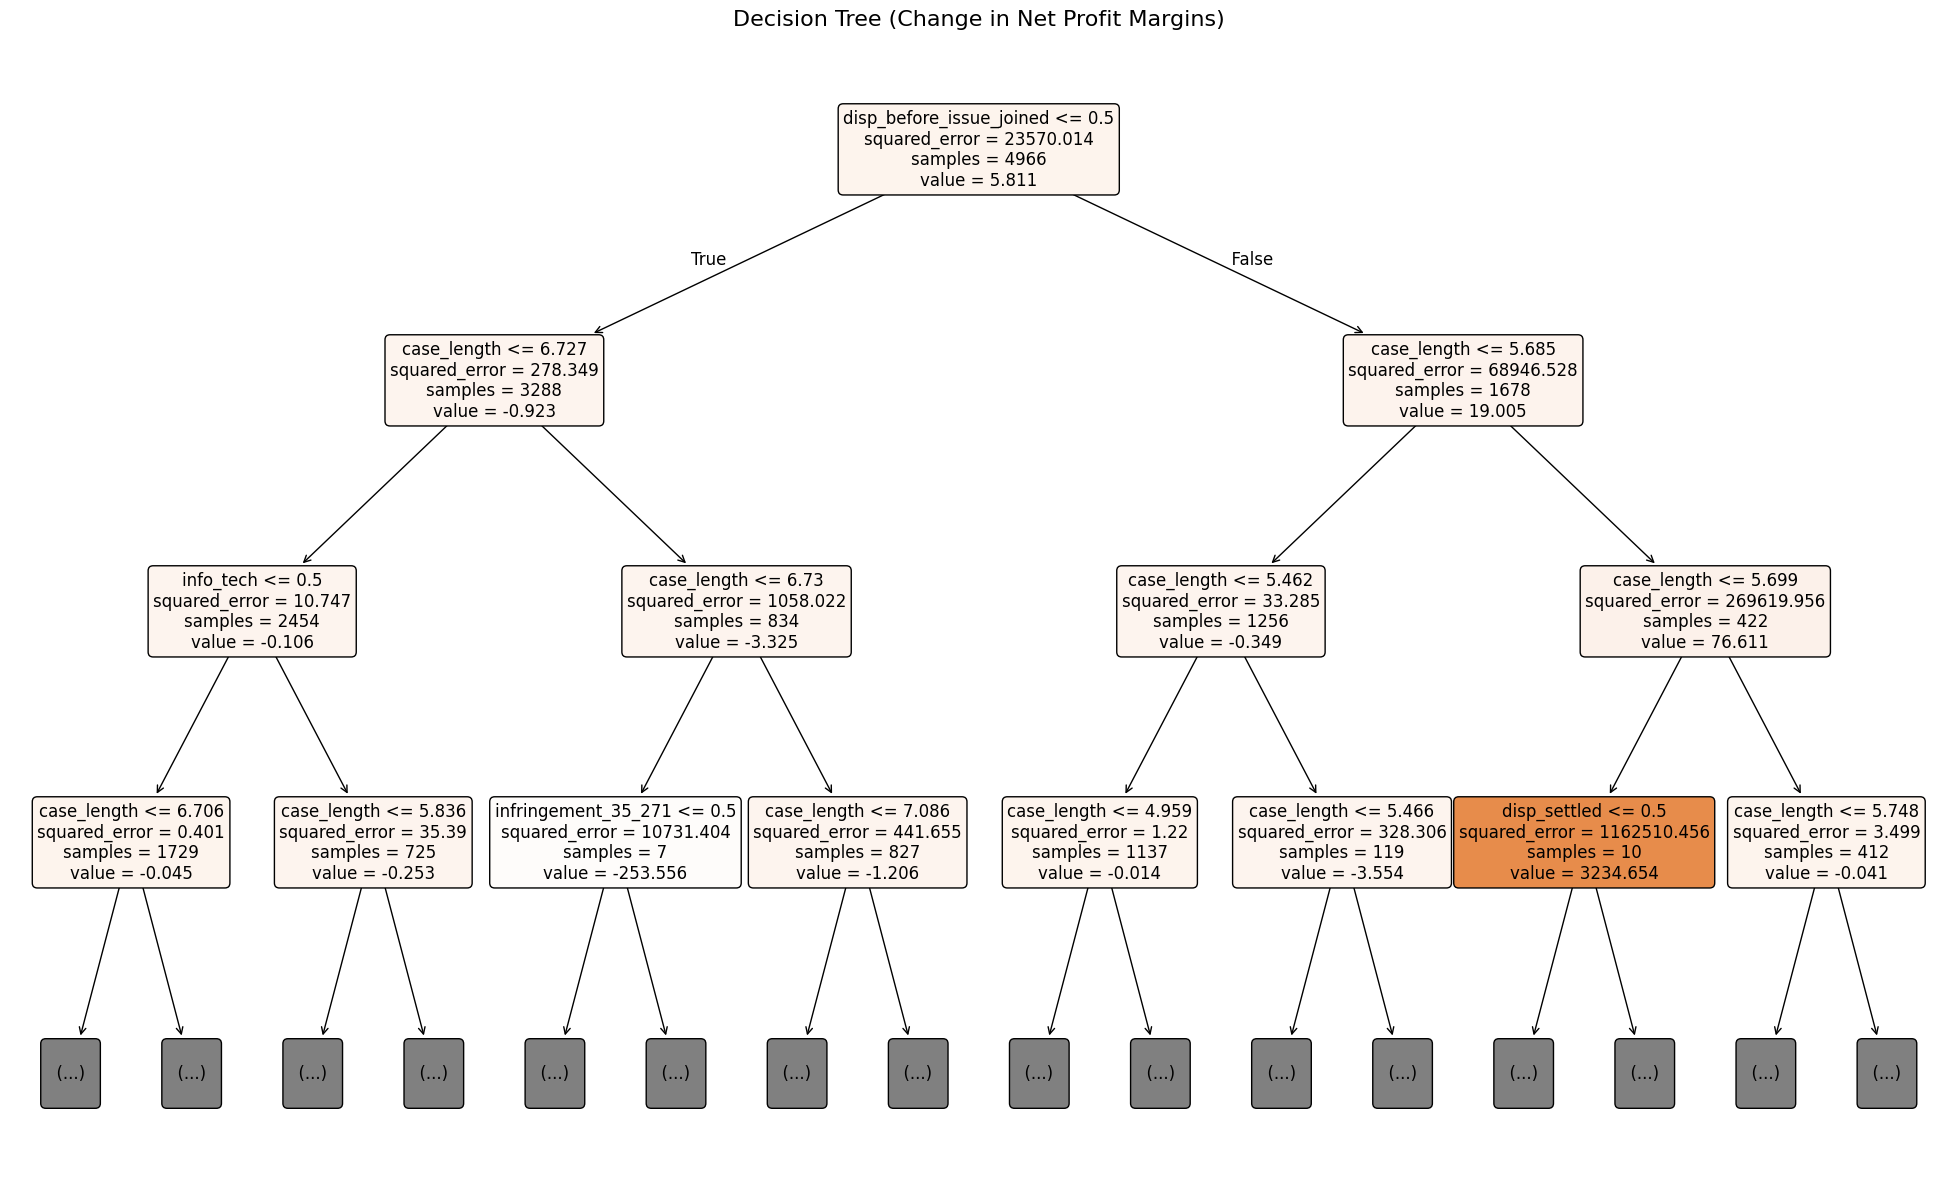

In [178]:
# Plot the decision tree with limited depth for visualization
plt.figure(figsize=(25, 15))  # You can adjust the figure size too
plot_tree(
    npm_regtree,
    feature_names=X_npm.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=12 )
plt.title("Decision Tree (Change in Net Profit Margins)", fontsize=16)
plt.show()

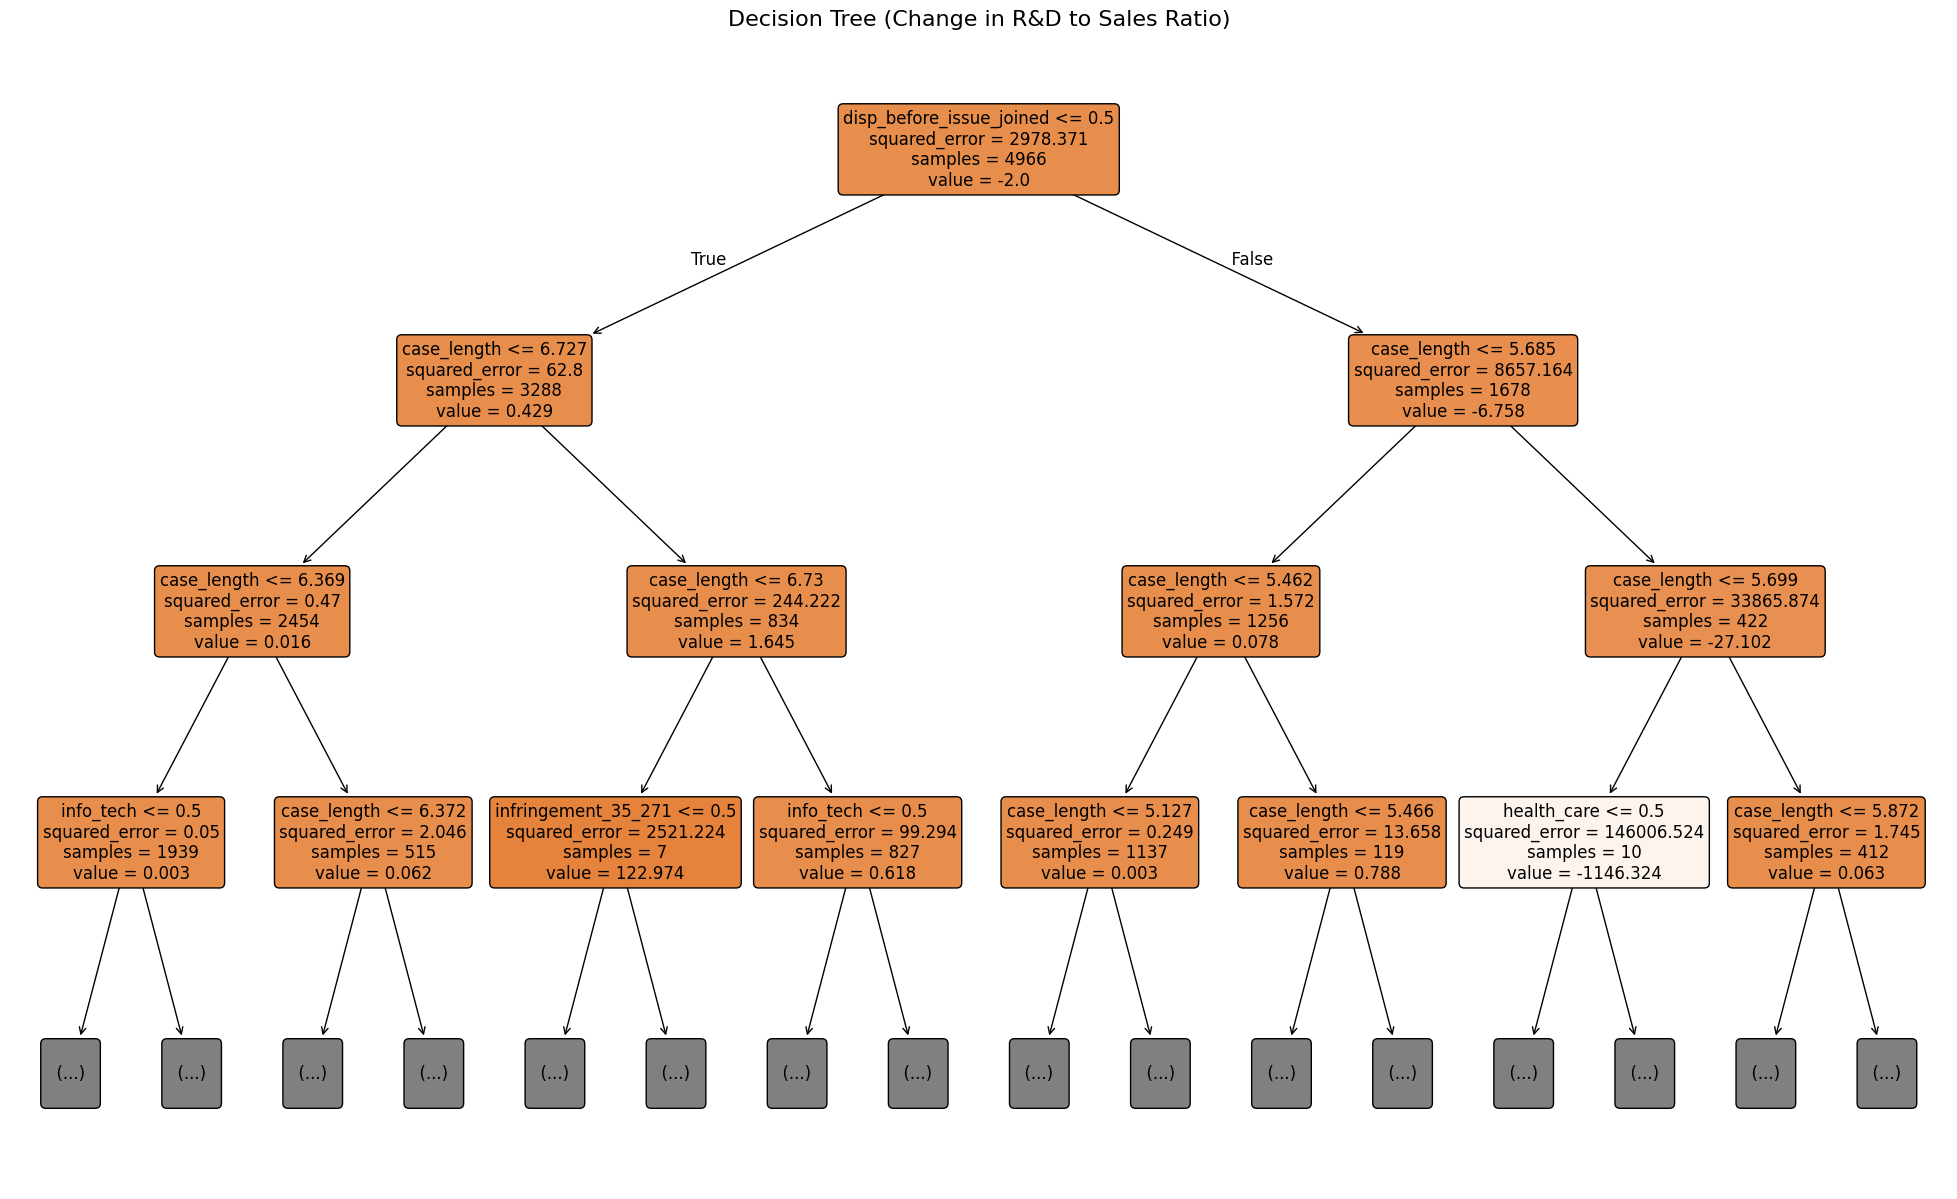

In [179]:
plt.figure(figsize=(25, 15))  # You can adjust the figure size too
plot_tree(
    rnd_regtree,
    feature_names=X_npm.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=12 )
plt.title("Decision Tree (Change in R&D to Sales Ratio)", fontsize=16)
plt.show()

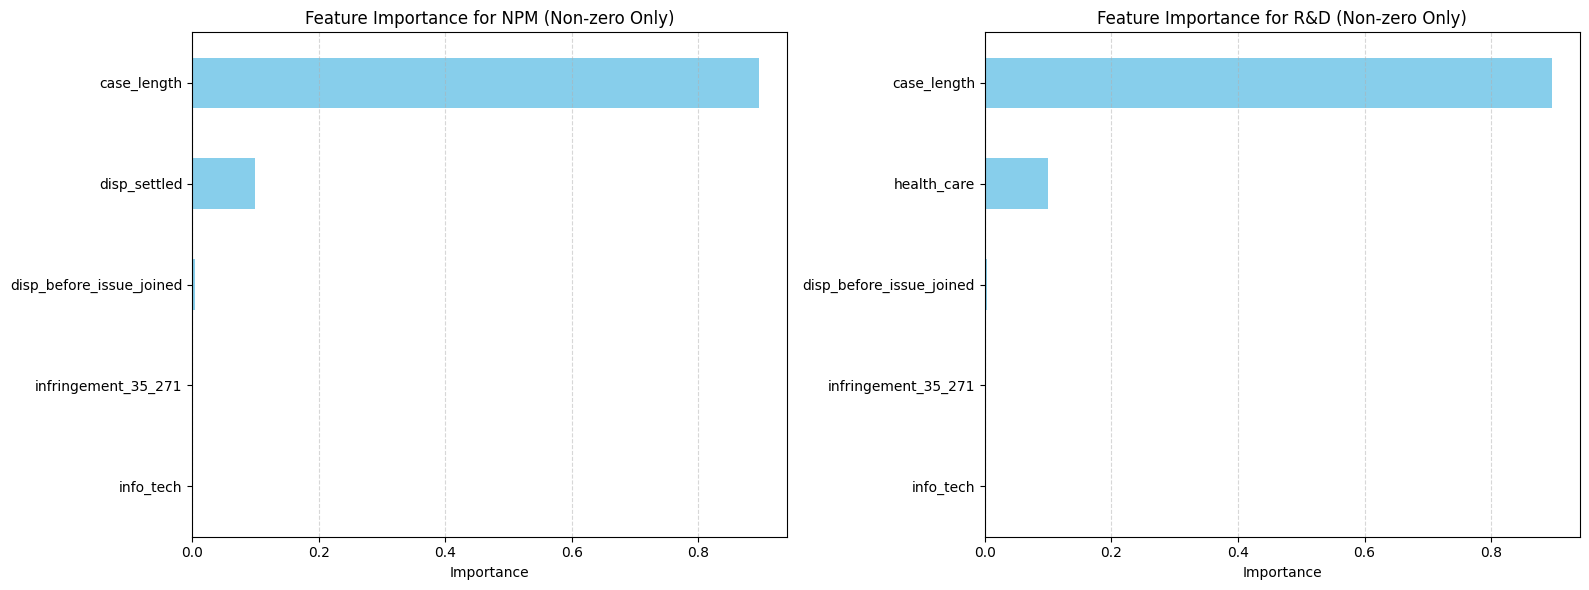

In [180]:
importances_npm = pd.Series(npm_regtree.feature_importances_, index=X_npm.columns)
importances_rnd = pd.Series(rnd_regtree.feature_importances_, index=X_npm.columns)

# Filter out zero-importance features
importances_npm = importances_npm[importances_npm > 0].sort_values(ascending=True)
importances_rnd = importances_rnd[importances_rnd > 0].sort_values(ascending=True)

#Plot actual vs predicted with x=y line
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for model 1
importances_npm.plot(kind='barh', color='skyblue', ax=axes[0])
axes[0].set_title('Feature Importance for NPM (Non-zero Only)')
axes[0].set_xlabel('Importance')
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

importances_rnd.plot(kind='barh', color='skyblue', ax=axes[1])
axes[1].set_title('Feature Importance for R&D (Non-zero Only)')
axes[1].set_xlabel('Importance')
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

fig.tight_layout()
plt.show()

Mean Squared Error: 6.178781271374087
R-Squarred: 0.9997378541579528


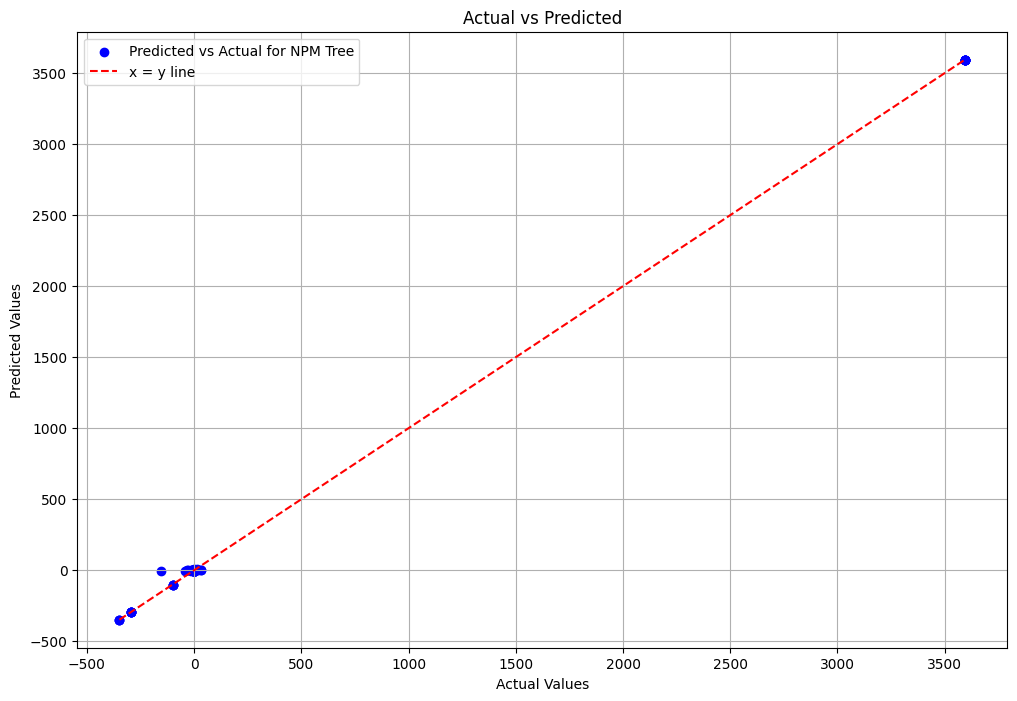

In [181]:
#Running Regression Trees for change in Net Profit Margins with all Xs
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

# non-NaN dataset
complete_data = complete_data[complete_data['delta_npm'].notna()]

# Features and target
X_npm = complete_data[list([col for col in complete_data.columns if col != 'delta_npm' and col != 'delta_rnd_sales'])]
y_npm = complete_data['delta_npm']

# Initialize and train model
npm_regtree = DecisionTreeRegressor(random_state=42, max_depth=5)
npm_regtree.fit(X_npm, y_npm)

# Predict and evaluate
y_pred_npm = npm_regtree.predict(X_npm)
mse = mean_squared_error(y_npm, y_pred_npm)
r2 = r2_score(y_npm, y_pred_npm)


print("Mean Squared Error:", mse)
print("R-Squarred:", r2)
#Plot actual vs predicted with x=y line

plt.figure(figsize=(12, 8))
plt.scatter(y_npm, y_pred_npm, label='Predicted vs Actual for NPM Tree', color='blue')
plt.plot([y_npm.min(), y_npm.max()], [y_npm.min(), y_npm.max()], 'r--', label='x = y line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

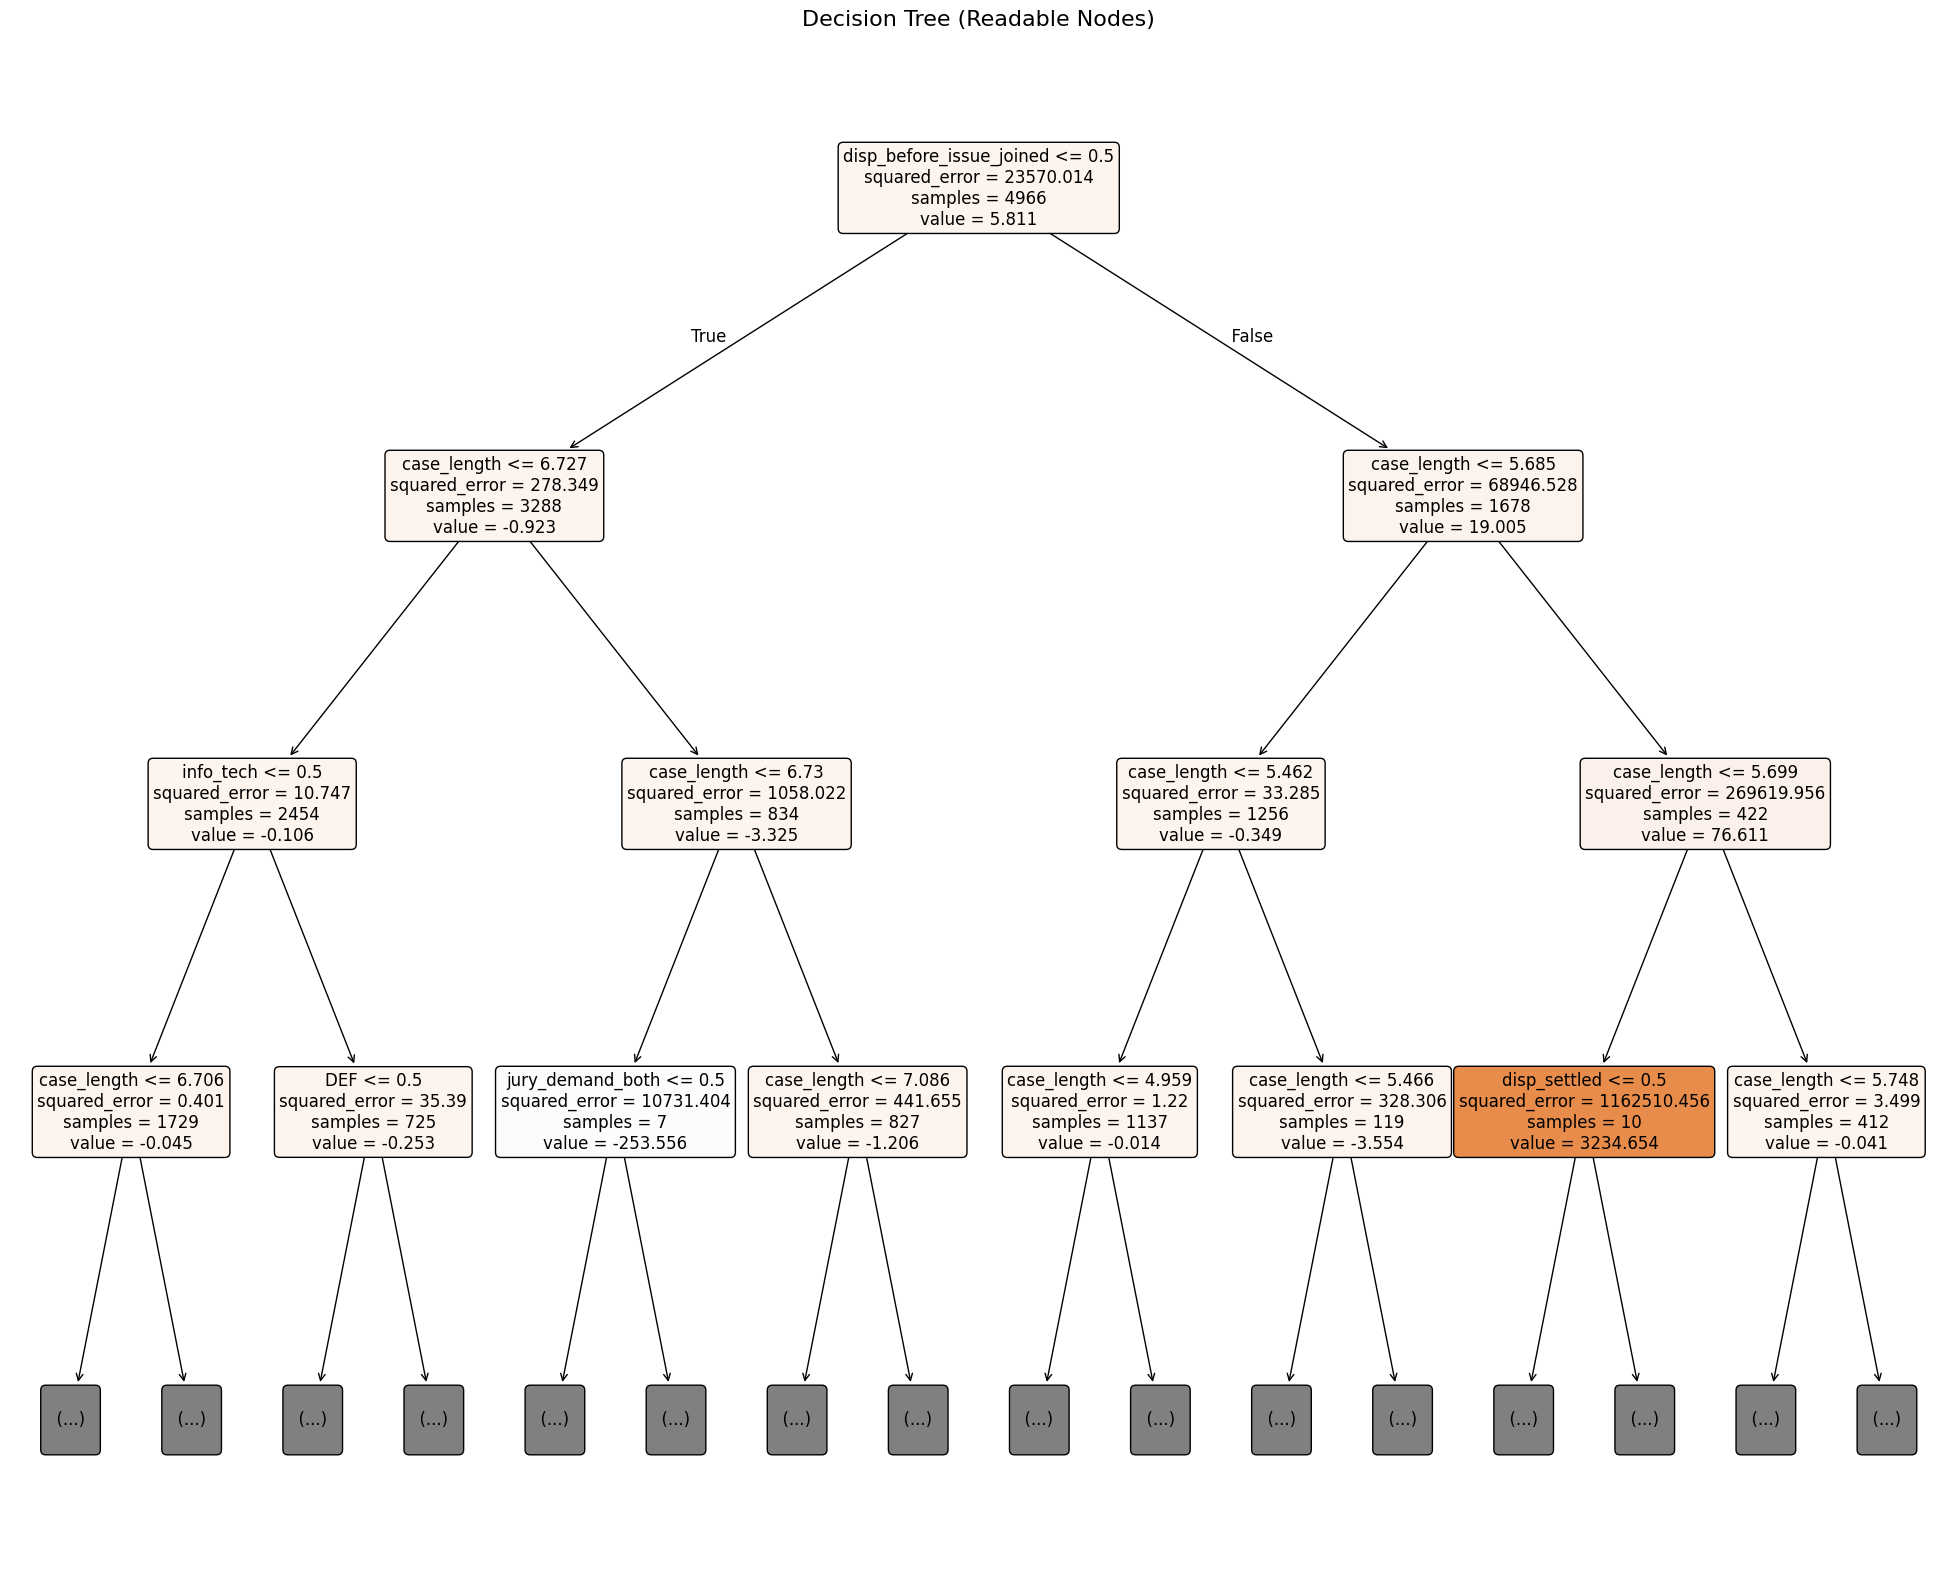

In [182]:
# Plot the decision tree with limited depth for visualization
plt.figure(figsize=(25, 20))  # You can adjust the figure size too
plot_tree(
    npm_regtree,
    feature_names=X_npm.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=12 )
plt.title("Decision Tree (Readable Nodes)", fontsize=16)
plt.show()

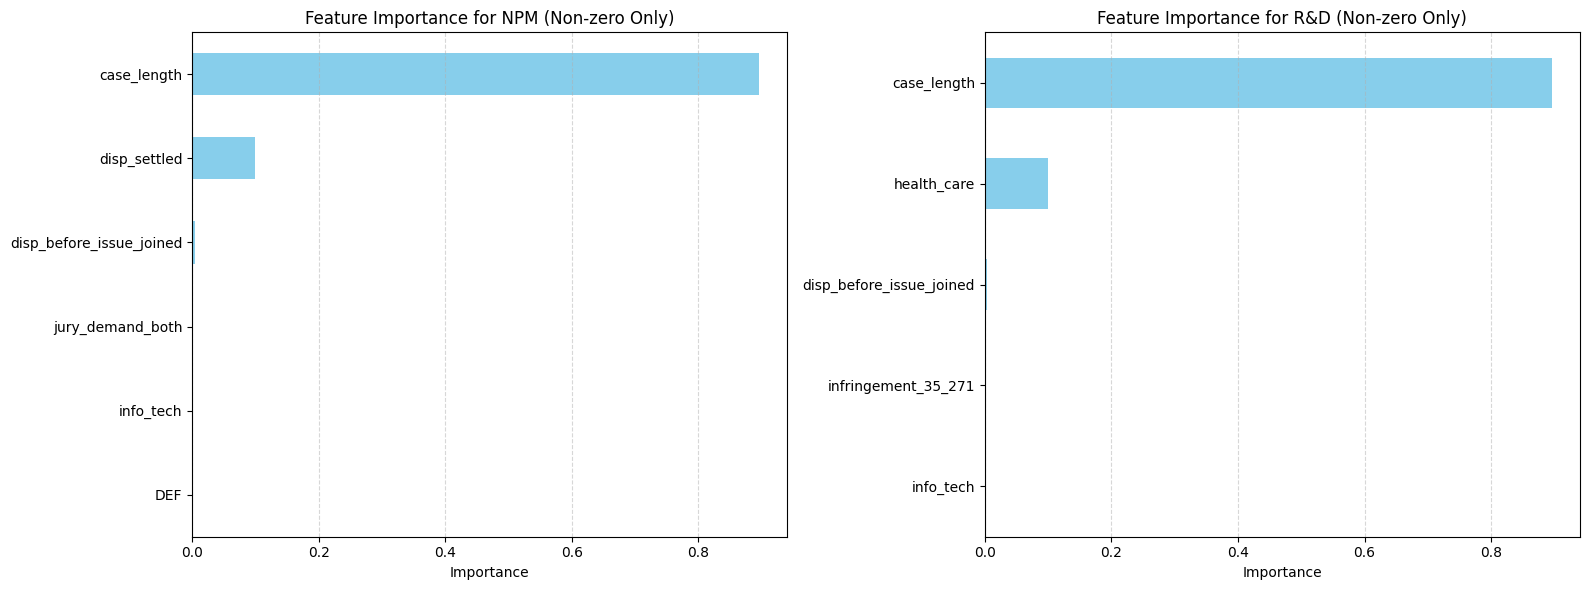

In [184]:
importances_npm = pd.Series(npm_regtree.feature_importances_, index=X_npm.columns)
importances_rnd = pd.Series(rnd_regtree.feature_importances_, index=X_rnd.columns)

# Filter out zero-importance features
importances_npm = importances_npm[importances_npm > 0].sort_values(ascending=True)
importances_rnd = importances_rnd[importances_rnd > 0].sort_values(ascending=True)

#Plot actual vs predicted with x=y line
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for model 1
importances_npm.plot(kind='barh', color='skyblue', ax=axes[0])
axes[0].set_title('Feature Importance for NPM (Non-zero Only)')
axes[0].set_xlabel('Importance')
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

importances_rnd.plot(kind='barh', color='skyblue', ax=axes[1])
axes[1].set_title('Feature Importance for R&D (Non-zero Only)')
axes[1].set_xlabel('Importance')
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

fig.tight_layout()

# ***Section 10: Conclusion:***

So to conclude, at this stage of the procress, we have only obtained observational estimates of litigation impacts on firms' profitability and research investment. However, this has yielded some very unexpected and suprising findings. Our most significant and surprising results was the 4000 percentage point, average increase in profitability of plaintiff firms that sue and have their cases dismissed before issue joining. Additionally, we observed that defendants can also face significant losses in profit margins, up to 45 percentage points. We also noted that IT defendant firms tend to increase their investment in R&D to the order of roughly 8 percentage points while Healthcare Plaintiffs tend to reduce their R&D investments by a staggering 11000 percentage points on average.

While some of these estiamte effects are incredibly large and surprising, at this stage none of them represent causal impacts of litigation outcomes. The next step would be incorporate a valid causal inference appraoch and address endogeneity, in order to understand the true costs of patent litigations.  

While these numbers do appear outrageous at first glance, factoring in the fact that these firms likely own mulitiple patents and enjoy a certain degree of Monopoly power, they become more beleivable. What is of interest is whether litigation outcomes are contributing to these massive profits and how much. This makes it even more


# ***References:***

* Bessen, J. (2012). The market effects of patent litigation. Research Policy, 37(2), 374–387.

* Bessen, J., & Meurer, M. J. (2012). The private costs of patent litigation. Journal of Law, Economics & Policy, 9(1), 59–96.

* Cohen, L., Gurun, U. G., & Kominers, S. D. (2018). Patent trolls: Evidence from targeted firms. American Economic Review, 108(6), 2431–2469.

* Cremers, K., Gaessler, F., Harhoff, D., & Helmers, C. (2018). The effect of patent litigation on firm performance: Evidence from event studies. SciSpace Research.

* Hall, B. H. (2019). The impact of patent litigation on corporate strategy and performance. NBER Working Paper No. 13644.

* Kang, J., & Nam, K. M. (2016). Do firms profit from patent litigation? The contingent roles of innovation and internationalization. Journal of Business Research, 69(10), 4898–4905.

* Licht, G., & Cremers, K. (2013). The effect of patent litigation on firm performance. ZEW Discussion Paper No. 13-015.

* Lin, C.-H., & Lin, S.-C. (2021). Financial market reaction to patent lawsuits against integrated circuit firms. Journal of Risk and Financial Management, 14(9), Article 433
